In [1]:
import os
import sys
import numpy as np
import itertools
import matplotlib.pyplot as plt
from math import pi
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import inspect
import orbithunter.ks as ks
import h5py
import time
import orbithunter.persistent_homology as ohgudhi
from orbithunter.persistent_homology import gudhi_distance_from_persistence, orbit_persistence
from orbithunter.shadowing import scanning_dimensions
import matplotlib.pyplot as plt 
from matplotlib import gridspec

# Covering space-time, an investigation.


# Table of contents
<a id='toc'></a>

## [A. Function declarations](#func)

## [B. Glossary](#glossary)

## [1. Introduction](#intro)

## [2. Family overlap](#family)

## [3. Group orbit overlap](#grouporbit)
    
## [4. Minimal covers](#minimal)

###  [4.a fundamental_domain==False](#minimal0)
###  [4.b fundamental_domain==True](#minimal1)

## [5. Current difficulties](#results)


<a id='func'></a>
# A. Function declarations.

In [8]:
def minimal_covering_set(covering, base, windows, cover_threshold, strides=(1,1), verbose=True, dtype=int):
    """ Find the smallest number of masks which cover a specified proportion of the total cover area."""
    assert cover_threshold < 1, 'cover threshold must be provided as a float between (0, 1).'
    total_mask = None
    orbit_masks = []
    sites_covered = []
    minimal_covering = {}
    # iterate over the covering, collecting the orbit masks and the number of detections in each
    # as well as the union of all masks. 
    for mask_key, mask in covering.items():
        if verbose:
            print('.', end='')
        window = windows[int(mask_key)]
        if mask.shape != base.shape:
            covering_mask = scanning_mask(mask, base, windows[int(mask_key)], strides).astype(int)
        else:
            covering_mask = mask.astype(int)
        orbit_masks.append(covering_mask)
        # Care more about the area covered rather than the number of detections/overlaps, therefore need to count 
        # in the orbit mask not the score mask. 
        sites_covered.append(covering_mask.astype(bool).sum())
        if total_mask is None:
            total_mask = covering_mask.copy()
        else:
            total_mask += covering_mask.copy()   
    
    area_covered = total_mask.astype(bool).sum()
    # Find the orbit mask with the largest covering. 
    max_area_cover_index = np.argsort(sites_covered)[::-1][0]
    minimal_covering[list(covering.keys())[max_area_cover_index]] = orbit_masks[max_area_cover_index]
    minimal_covering_union = orbit_masks[max_area_cover_index].copy()
    cover_percentage = minimal_covering_union.astype(bool).sum() / total_mask.astype(bool).sum()
    # If the cover percentage is less than the provided threshold, then look for more masks to add.
    
    if verbose:
        print(len(minimal_covering), cover_percentage)
    percentages = []
    percentages.append(cover_percentage)
    while cover_percentage < cover_threshold:
        # the next mask best mask is the one which covers areas not covered by the current mask. 
        orthogonalities = []
        for m in orbit_masks:
            # The next mask which contributes the most amount of currently uncovered area is the one
            # which increases the cover the most (the union) subtracting what is already covered. i.e. B and not A in logical
            # terms. Union minus current. Alternatively, convert to vector, find mask with largest perpendicular component.
            complement_area_number = (np.logical_or(minimal_covering_union.astype(bool), m.astype(bool)).astype(int) 
                                      - minimal_covering_union.astype(bool).astype(int)).sum()
            orthogonalities.append(complement_area_number)
        # save the next mask's information 
        
        for next_detection_index in np.argsort(orthogonalities)[::-1]:
            if list(covering.keys())[next_detection_index] not in minimal_covering.keys():
                minimal_covering[list(covering.keys())[next_detection_index]] = orbit_masks[next_detection_index]
                break
            
        # The union of the masks up until this point provides the cover
        if dtype is int:
            minimal_covering_union = orbit_masks[next_detection_index]+minimal_covering_union
        else:
            minimal_covering_union = np.logical_or(orbit_masks[next_detection_index], minimal_covering_union).astype(bool)

        # Calculate the amount of area covered with inclusion of the next mask. 

        cover_percentage = minimal_covering_union.astype(bool).sum() / total_mask.astype(bool).sum()
        percentages.append(cover_percentage)
        if verbose:
            print(len(minimal_covering), cover_percentage)
    return minimal_covering, minimal_covering_union, percentages


def covering_union(covering, base, windows, strides=(1,1), filename=None, groupname=None, dtype=int):
    """ Take the union of masks in a covering dict. 
    
    """
    union_mask = None
    for mask_key, mask in covering.items():
        # How to convert score mask to orbit mask depends on the shape of the window. 
        window = windows[int(mask_key)]

        if mask.shape != base.shape:        
            covering_mask = scanning_mask(mask, base, windows[int(mask_key)], strides).astype(int)
        else:
            covering_mask = mask.astype(int)
            
        # All orbit masks, however, have the same size; 
        if union_mask is None:
            union_mask = covering_mask.copy()
        else:
            union_mask += covering_mask.copy()   
            
        if filename is not None:
            OrbitKS(state=covering_mask.astype(int), parameters=base.parameters,
                    basis='field').to_h5(filename=filename, groupname=groupname,
                                         dataname=str(mask_key), verbose=True)
            
    return union_mask.astype(dtype)


    

def l2_difference(base_slice, window, *args, **kwargs):
    return np.linalg.norm(base_slice - window)

def compare_cover_plot(mask, second_mask, figsize=(10,10), dtype=int):
    """ Compare a mask, the total cover, and the mask's complement. """
    if dtype is int:
        crange = np.max([mask.max(), second_mask.max()])
    else:
        crange = 1
    # the cover provided by mask
    _ = plt.figure(figsize=figsize)
    _ = plt.title('First mask')
    if dtype is bool:
        _ = plt.imshow(mask.astype(bool).astype(int), vmin=0, vmax=crange)
    else:
        # cant plot bool
        _ = plt.imshow(mask, vmin=0, vmax=crange)  
    _ = plt.colorbar()
    _ = plt.show()
    _ = plt.close()
    # the cover provided by second_mask; namesake from the fact that mask is usually a subset.
    _ = plt.figure(figsize=figsize)
    _ = plt.title('Second mask')

    if dtype is bool:
        _ = plt.imshow(second_mask.astype(bool).astype(int), vmin=0, vmax=crange)
    else:
        # cant plot bool
        _ = plt.imshow(second_mask, vmin=0, vmax=crange)  
    _ = plt.colorbar()
    _ = plt.show()
    _ = plt.close()
    # The cover in second_mask which is not provided by mask. I.e. complement of mask intersect with second_mask. 
    _ = plt.figure(figsize=figsize)
    _ = plt.title('Covered by second mask but not first mask')
    complement = second_mask*np.logical_and(np.invert(mask.astype(bool)),
                                           second_mask.astype(bool)).astype(int)
    
    print('The first mask covers {}% of space-time'.format(100*mask.astype(bool).sum()/mask.size))
    print('The second mask covers {}% of space-time'.format(100*second_mask.astype(bool).sum()/second_mask.size))
    intersect_count = np.logical_and(mask.astype(bool), second_mask.astype(bool))
    union_count =  np.logical_or(mask.astype(bool), second_mask.astype(bool))
    print('{} = intersection/union = overlap%'.format(100*intersect_count.astype(bool).sum()/union_count.sum()))

    if dtype is bool:
        _ = plt.imshow(complement.astype(bool).astype(int), vmin=0, vmax=crange)
    else:
        # cant plot bool
        _ = plt.imshow(complement, vmin=0, vmax=crange) 
    _ = plt.colorbar()
    _ = plt.show()
    _ = plt.close()    
    return None

def plot_covering_factors(covering, base, windows, strides=(1,1), verbose=True, figsize=(6,6)):
    """ Given a covering, plot its constituents or plot its union, w"""

    covering_percentages = []
    for mask_key in covering:
        if covering[mask_key].shape != base.shape:
            covering_mask = scanning_mask(covering[mask_key], base, windows[int(mask_key)], strides)
        else:
            covering_mask = covering[mask_key]
        bool_mask = covering_mask.astype(bool).copy()
        bool_mask[bool_mask!=0]=1
        covering_percentage = covering_mask.astype(bool).sum()/covering_mask.size
        print('{}% space-time covered by orbit {}'.format(100*covering_percentage, mask_key))

        # plot it
        fig = plt.figure(figsize=figsize) 
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5]) 
        ax0 = plt.subplot(gs[0])
        ax0.imshow(windows[int(mask_key)].state, cmap='jet')
        ax1 = plt.subplot(gs[1])
        im = ax1.imshow(np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool))), cmap='jet')
#             _ = plt.colorbar(im)
        _ = plt.show()
        _ = plt.close()
        print('##############')
        
def plot_covering_union(covering, base, windows, strides=(1,1), verbose=True, figsize=(6,6)):
        covering_mask = covering_union(covering, base, windows, strides)
        bool_mask = covering_mask.astype(bool).copy()
        bool_mask[bool_mask!=0]=1
        base.plot(figsize=figsize)
        base.__class__(state=np.ma.masked_array(base.state, mask=bool_mask, fill_value=np.nan),
                                     basis='field', parameters=base.parameters).plot(figsize=figsize)
        base.__class__(state=np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool)), fill_value=np.nan),
                                     basis='field', parameters=base.parameters).plot(figsize=figsize)

<a id='glossary'></a>
# B. Glossary.


**Covering orbits** : The set of orbits whose shadowing constitutes the cover. 

**Cover** : The regions of space-time detected as shadowing of a set of periodic orbits, called the covering orbits.

**Minimal covering orbits** : A subset of the covering orbits which reproduces a certain proportion of the cover. 

**Minimal cover**: The space-time shadowed by the orbits in the minimal covering set. 

**Family**: A collection of orbits which are all related by continuation

**Group orbit**: The collection of equivariant orbits generated by applying symmetry operations to a single orbit, i.e. a single representative of a family. 

[Return to table of contents](#toc)
<a id='intro'></a>
# Introduction

With results from ```continuation.ipynb```, ```shadowing.ipynb``` and ```shadowing_statistics.ipynb``` we can begin to test the covering process. Even in the context of the "family" method for calculating covering, if the number of group orbit members for each family member in the covering is large, the computations for a single family on a single domain can take a *very* long time. Therefore, it behooves us to determine a subset of group orbit members which provide the most efficient covering, in terms of computational time per area. The idea here being that more orbit family members likely only contribute to overlaps. 

So, the main objective before beginning the full covering computations (i.e. determining the area proportions and statistical averages) is to first work through the following list of tasks:

    1. Determine an efficient number of members per family to use for covering
    2. Determine an efficient number of group members per family member to use for covering
    4. Determine how the different metrics affect these results 

The different metrics mentioned in this list include the $L_2$ norm of the difference between windows $|u-v|$, the "amplitude difference" $u^2-v^2$, and the bottleneck distance between persistence diagrams. Due to the pointwise nature of the first two metrics, it is likely that these will require many more group orbit members and family members than the bottleneck distance metric, which is topological in nature. While important, this last task of determining the best metric is covered only very briefly 

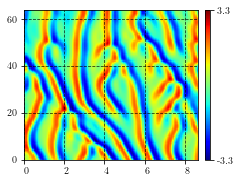

In [15]:
windows = [x.transform(to='field') for x in read_h5('./local/minimal_cover.h5')]
base = read_h5('./local/small_patches.h5', '0')
base.plot()
strides=(1,1)
fundamental_windows = tuple([x.to_fundamental_domain() for x in windows])

Import critical values; the specificity of each key is somewhat annoying but it is not worth the effort of making this better. 

In [40]:
strictness = 0
critical_persistence_values = []
with h5py.File('./local/critical_values.h5', 'r') as file:
    critical_persistence_values.append(file['defect/bottleneck_distance_fundamental_domain'][...][strictness])
    critical_persistence_values.append(file['drifter/bottleneck_distance_fundamental_domain'][...][strictness])
    critical_persistence_values.append(file['large_defect/bottleneck_distance_fundamental_domain'][...][strictness])
    critical_persistence_values.append(file['wiggle/bottleneck_distance_fundamental_domain'][...][strictness])

critical_amp_diff_values = []
with h5py.File('./local/critical_values.h5', 'r') as file:
    critical_amp_diff_values.append(file['defect/amplitude_difference_fundamental_domain'][...][strictness])
    critical_amp_diff_values.append(file['drifter/amplitude_difference_fundamental_domain'][...][strictness])
    critical_amp_diff_values.append(file['large_defect/amplitude_difference_fundamental_domain'][...][strictness])
    critical_amp_diff_values.append(file['wiggle/amplitude_difference_fundamental_domain'][...][strictness])

critical_l2_diff_values = []
with h5py.File('./local/critical_values.h5', 'r') as file:
    critical_l2_diff_values.append(file['defect/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values.append(file['drifter/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values.append(file['large_defect/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values.append(file['wiggle/l2_difference_fundamental_domain'][...][strictness])

[Return to table of contents](#toc)
# Preliminary testing

As a preliminary trial, run the covering routine with only a small set of covering orbits, not accounting for their
symmetry group orbits or continuous families. This will give an idea as to whether it will be possible to cover the space. Each fundamental orbit has a discretization of (32, 32) even though they do not have the same dimensions; simply for uniformity. however rectangular and different discretization sizes in a single ```cover``` function are allowed if replacement=True. I thought that I could improve performance by caching values during the persistent homology calculations but when the number of values in memory gets too large it actually becomes faster to recompute rather than search for values in an array. 

This calculation is "with replacement". No replacement means that once a detection has been made at a site, it will be skipped over for future orbits in the covering set. This is a cumulative process which reduces the numbers of computations for each successive orbit. The motivation being that a region of space-time only shadows a single orbit at a time, by definition. 
However, because we actually want to look at the overlaps that occur, replacement will be left on.

Overlaps are good and bad, depending on the context. They are bad when overlaps occur between different families, as the area which "belongs" to each family becomes undefined. Overlaps are good when they occur with respect to members of the same family and group orbits; this is an indication that the number of covering orbits can be reduced, because the information they provide is redundant. 


#### Metric comparison

First, with a small patch, check the performance of the different metrics as a simple guide for which one to use for the preliminary testing.

In [41]:
score_type = 'persistence'
scoring_function = gudhi_distance_from_persistence
persistence_function = orbit_persistence

t0p=time.time_ns()/10**9
persistence_cover = cover(base, critical_persistence_values, fundamental_windows,
                          score_type=score_type,
                          scoring_function=scoring_function,
                          persistence_function=persistence_function,
                          replacement=True,
                          base_orbit_periodicity=(False, False),
                          strides=(1, 1),
                          verbose=True)
t1p=time.time_ns()/10**9
print('\nPersistence metric covering took {:.2f} seconds to complete'.format(t1p-t0p))

#-----------#-----------#-----------#-----------
Persistence metric covering took 151.88 seconds to complete


In [42]:
t0ad=time.time_ns()/10**9
amplitude_difference_cover = cover(base, critical_amp_diff_values, fundamental_windows,
                                      replacement=True,
                                       scoring_function=amplitude_difference,
                                      base_orbit_periodicity=(False, False),
                                      strides=(1, 1),
                                      verbose=True,
                                      dtype=int)
t1ad=time.time_ns()/10**9
print('\nAmplitude metric covering took {:.2f} seconds to complete'.format(t1ad-t0ad))

#-----------#-----------#-----------#-----------
Amplitude metric covering took 2.11 seconds to complete


In [43]:
t0l2=time.time_ns()/10**9
l2_difference_cover = cover(base, critical_l2_diff_values, fundamental_windows,
                          scoring_function=l2_difference,
                          replacement=True,
                          base_orbit_periodicity=(False, False),
                          strides=(1, 1),
                          verbose=True)
t1l2=time.time_ns()/10**9
print('\nL2 metric covering took {:.2f} seconds to complete'.format(t1l2-t0l2))

#-----------#-----------#-----------#-----------
L2 metric covering took 2.21 seconds to complete


AttributeError: 'NoneType' object has no attribute 'astype'

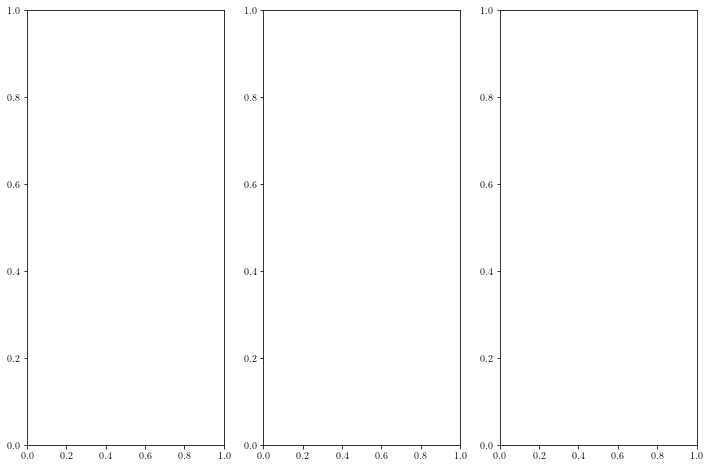

In [44]:
fig, axes = plt.subplots(1,3, figsize=(12,8))
labels = ['bottleneck distance', 'amplitude difference', 'L2 distance']
for ax, lab, cover_dict in zip(axes.flatten(), labels,
                               [persistence_cover, amplitude_difference_cover, l2_difference_cover]):
    field = covering_union(cover_dict, base, fundamental_windows, strides)
    if field is None:
        field=0*base.state
    im = ax.imshow(field.astype(int), vmin=0, vmax=5)
    ax.set_xlabel(lab)
_ = plt.show()
_ = plt.close()

[Return to table of contents](#toc)
# Methodology 

Plot the entire covering, both factorized and the union, and then compare with the "minimal" cover. Which
computes the subset of elements which cover at least a user specified percentage of the *covered* area. **NOT** the total area,
as clearly for "bad" covers this threshold may be unobtainable. If the cover threshold is too strict, then it is likely
that the minimal covering set will be the entire cover; something to keep in mind.

#### Plot of each constituent separately

22.149658203125% space-time covered by orbit 2


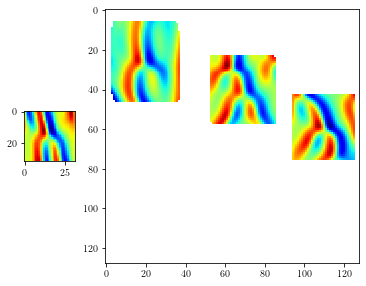

##############
27.0751953125% space-time covered by orbit 1


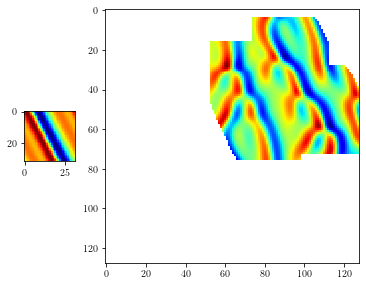

##############
16.12548828125% space-time covered by orbit 0


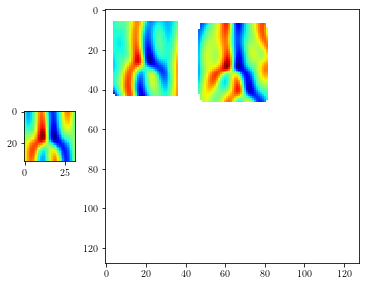

##############
4.19921875% space-time covered by orbit 3


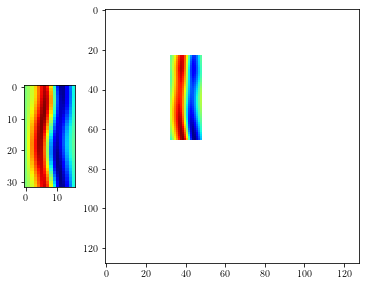

##############


In [21]:
plot_covering_factors(l2_difference_cover, base, fundamental_windows, strides=(1,1), verbose=True)

#### Plot of the union

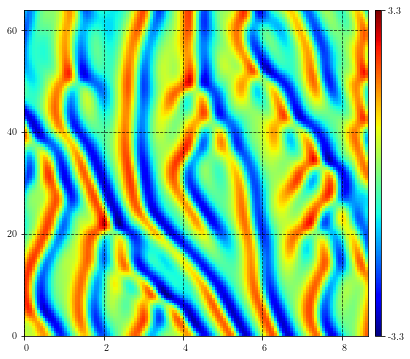

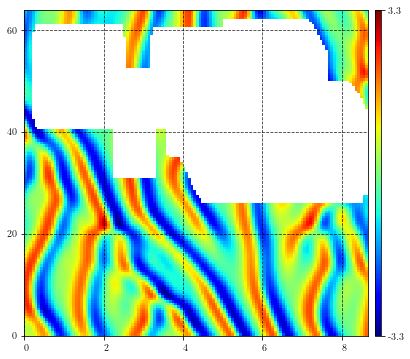

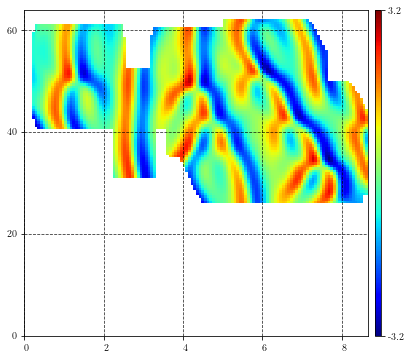

In [22]:
plot_covering_union(l2_difference_cover, base, fundamental_windows, strides=(1,1), verbose=True)

And now the "minimal" cover which covers at least 80% of the area covered in the plots above.

....1 0.6421540243196294
2 0.8844817602779386
27.0751953125% space-time covered by orbit 1


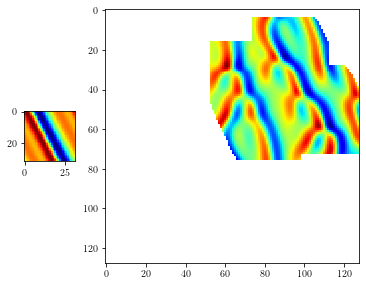

##############
16.12548828125% space-time covered by orbit 0


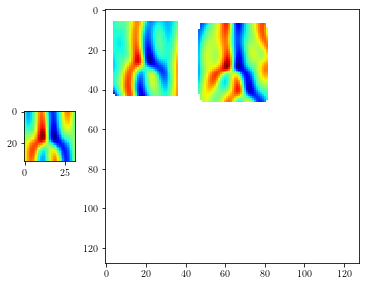

##############


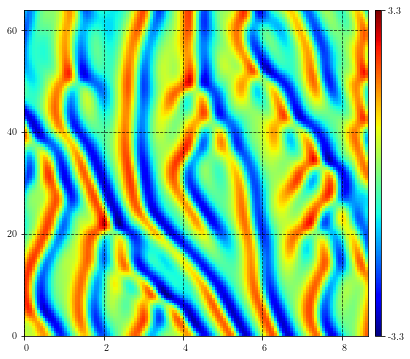

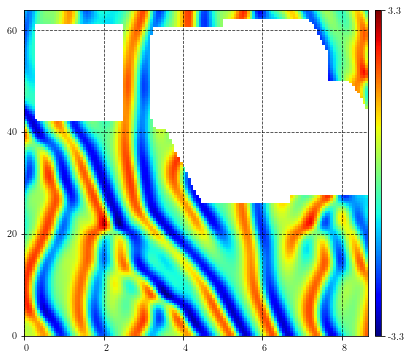

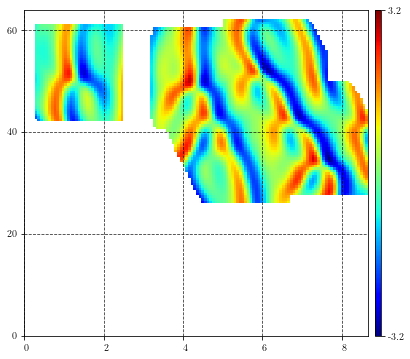

In [24]:
cover_threshold=0.8
minimal_covering, minimal_covering_union, percentage = minimal_covering_set(l2_difference_cover, base, fundamental_windows,
                                                                            cover_threshold, strides=(1,1))
plot_covering_factors(minimal_covering, base, fundamental_windows, strides=(1,1), verbose=True)
plot_covering_union(minimal_covering, base, fundamental_windows, strides=(1,1), verbose=True)

It seems that the $L_2$ difference is having a hard time distinguishing defects and the relative equilibrium solution. This is a problem, but one that is saved for later. This covering was performed with an incredible small set of windows. However, if I was to take this result to the end all and be all I would say the following. It seems hard to make detections where there seems to be local spatial drift velocity which is not built into the windows apriori. 

Unfortunately, spatial translation velocity of this type is only built into RelativeOrbitKS
and currently the cover function only supports rectangular windows, not parallelepipeds. Therefore, I imagine these regions will be hard to cover with the current methods. The current idea for a work around would be to put a border around the paralleliped such that it is contained in a rectangular array and the border cancels out with the base orbit's field in that region, i.e. mask the border. Computed the pointwise metrics using an "actual" parallelipided would be hard I think, however I offer an alternative in the [results](#results) section.

[Return to table of contents](#toc)
<a id='family'></a>
## Overlap between subsampling of a single family. 

Calculate the covers with respect to the 149 different orbits in the large defect family; this takes approximately an hour and a half and so the covers are saved for later use. This uses a large trajectory, produced by time integration, which actually has spatial periodicity. While this takes an exceptional amount of time compared to the smaller base orbits, I believe it is necessary to get an accurate depiction of the number of overlaps. Additionally, the strictest tolerance is used, meaning that detections are expected 0.01% of the time, based on the previously computed distribution. Import these thresholds.

In [856]:
strictness = 0
critical_l2_diff_values = []
with h5py.File('critical_values.h5', 'r') as file:
    critical_l2_diff_values.append(file['defect/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values.append(file['drifter/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values.append(file['large_defect/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values.append(file['wiggle/l2_difference_fundamental_domain'][...][strictness])

Import the large trajectory segment which will be covered.

In [12]:
large_patch = read_h5('large_patches.h5', '0/')
large_defect_family = tuple([x.to_fundamental_domain() for x in read_h5('large_cover.h5', 'large_defect/')])
large_defect_family_critical_values = tuple([critical_l2_diff_values[2]]*len(large_defect_family))

t0fam=time.time_ns()/10**9
large_defect_covering = cover(large_patch, large_defect_family_critical_values, large_defect_family,
                            score_type='pointwise',
                            scoring_function=l2_difference,
                            replacement=True,
                            base_orbit_periodicity=(False, True),
                            strides=(1,1),
                            verbose=False)
t1fam=time.time_ns()/10**9
print('Family covering took {:.2f} minutes to complete'.format((t1fam-t0fam)/60.))

Family covering took 97.41 minutes to complete


Save the covering masks, and produce their "union" in the meantime (here the masks are of integer data and summer so that more overlaps correspond to larger values.).

In [559]:
ld_family_total =  covering_union(large_defect_covering, large_patch,
                                  large_defect_family, (1, 1),
#                                   filename='family_covering_masks.h5', groupname='',
                                  dtype=int)

In [ ]:
# ld_family_covering = {}
# with h5py.File('large_defect_family_covering.h5', 'r') as file:
#     for key in file:
#         ld_family_covering[key] = file[key][...].astype(bool)

Next, the "minimal" subset with respect to this covering union can be computed, this is the smallest number of masks which covers a certain proportion of the covered union (not the total space-time, mind you). Use 80% here. The reason for this is because I expect the metric to vary continuously and so the same shadowing region will be picked up multiple times; to reduce the number overlaps only take a proportion of the area. The problem is that there is no way (currently) to extract the *interior* of these regions.   

In [59]:
cover_threshold=0.8
minimal_covering, minimal_covering_union, percentage = minimal_covering_set(large_defect_covering, 
                                                                            large_patch, large_defect_family,
                                                                            cover_threshold, strides=(1,1), verbose=True)

1 0.8072786584433458


Compare the minimal covering to the total covering, and see how well this subset (a single mask in this case) reproduces the total mask. What does this mean? It means that instead of 149 different members of a continuous family, only a single representative is needed to reproduce the same results. With this result, we can move to the investigation of the group orbits of these representative.

The first mask covers 4.575975406804734% of space-time
The second mask covers 5.668396357248521% of space-time


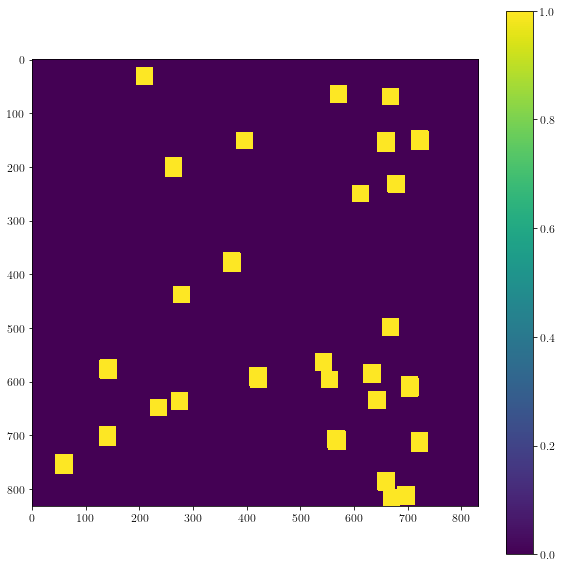

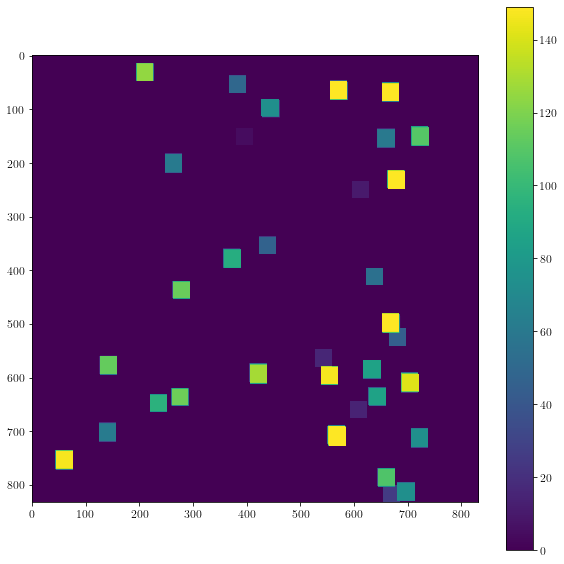

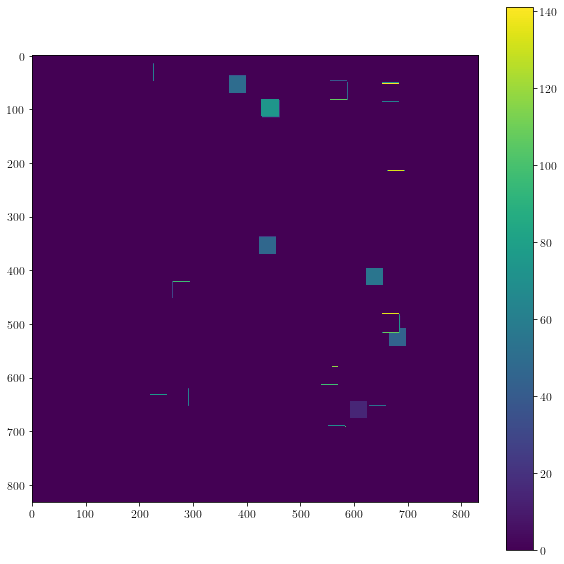

In [61]:
compare_cover_plot(minimal_covering_union, ld_family_total, figsize=(10,10), dtype=int)

4.575975406804734% space-time covered by orbit 83


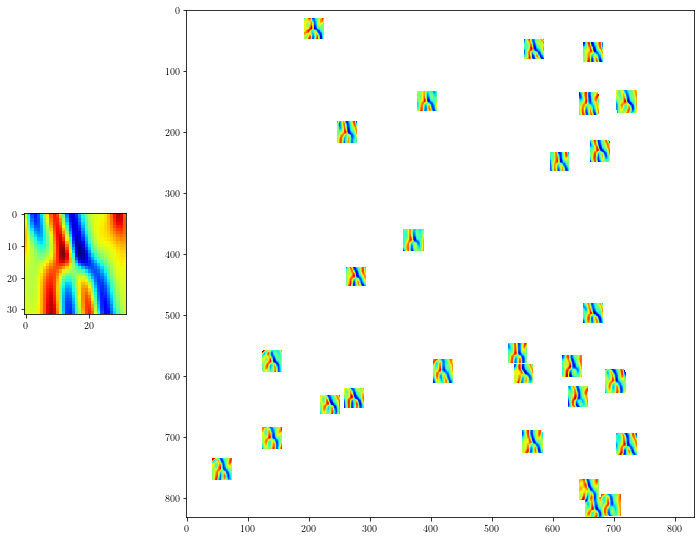

##############


In [19]:
plot_covering(minimal_covering, large_patch, large_defect_family,
              strides=(1,1), verbose=True, plot_type='factors',
              figsize=(12,12))

[Return to table of contents](#toc)
<a id='grouporbit'></a>
## Overlap between subsampling of a single group orbit. 

The next goal is to determine is how much redundancy there is in a cover using a group orbit as a covering set;
that is, the set of symmetry related fields. To test this, the same strictness is applied to 128 group orbit members
of the large defect. 

I think what we will end up using is a hybrid metric which combines $L_2$ distance and persistence diagram distance.

In [32]:
# fundamental_domain transformation must be done last; therefore take fundamental domains of group orbit not group orbit
# of fundamental_domain. 
large_defect_group_orbit = tuple(windows[2].group_orbit(rolls=(4, 4), fundamental_domain=True))
large_defect_group_orbit_critical_values = tuple([critical_l2_diff_values[2]]*len(large_defect_group_orbit))

In [33]:
t0g=time.time_ns()
group_orbit_covering = cover(large_patch, large_defect_group_orbit_critical_values, large_defect_group_orbit,
                            scoring_function=l2_difference,
                            replacement=True,
                            base_orbit_periodicity=(False, True),
                            strides=(1, 1),
                            verbose=False)
t1g=time.time_ns()


In [34]:
print('Group orbit covering took {:.2f} minutes to complete'.format((t1g-t0g)/(10**9 * 60)))

Group orbit covering took 105.69 minutes to complete


In [ ]:
# Arbitrary number to get cover percentages for plotting. 
cover_threshold=0.99
_, _, percentages = minimal_covering_set(group_orbit_covering, large_patch,
                                         large_defect_group_orbit, cover_threshold,
                                         strides=(1,1), verbose=False)

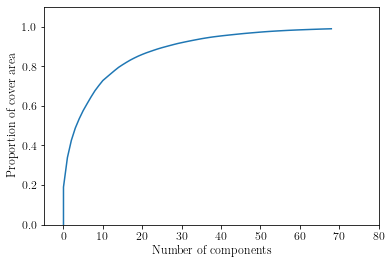

In [799]:
plt.plot([0]+list(range(len(percentages))), [0]+percentages)
plt.xlabel('Number of components')
plt.ylabel('Proportion of cover area')
plt.xlim([-5, 80])
plt.ylim([0, 1.1])
plt.show()

Unfortunately, the group orbit does not overlap nearly as much as the continuous family members, indicating that sampling the group orbit (at least with this metric) is very important. To analyze the results of group orbit covering, first find the minimal covering and compare it to the total covering. Then plot the constituents of the covering and their corresponding contributions to the cover. First, look at the dependence on cover percentage vs number of minimal cover constituents.

In [800]:
cover_threshold=0.8
minimal_covering, minimal_covering_union, _ = minimal_covering_set(group_orbit_covering, large_patch,
                                                                   large_defect_group_orbit,cover_threshold,
                                                                   strides=(1,1), verbose=False)

group_orbit_covering_union = covering_union(group_orbit_covering, large_patch,
                                            large_defect_group_orbit, (1, 1),
#                                            filename='group_orbit_covering_masks.h5',
#                                             groupname='',
                                            dtype=int)

The comparison between the minimal and total cover; the first plot is the minimal cover; higher values indicating more overlaps. The second plot is the full group orbit covering, and the third plot is essentially the difference between the two. 

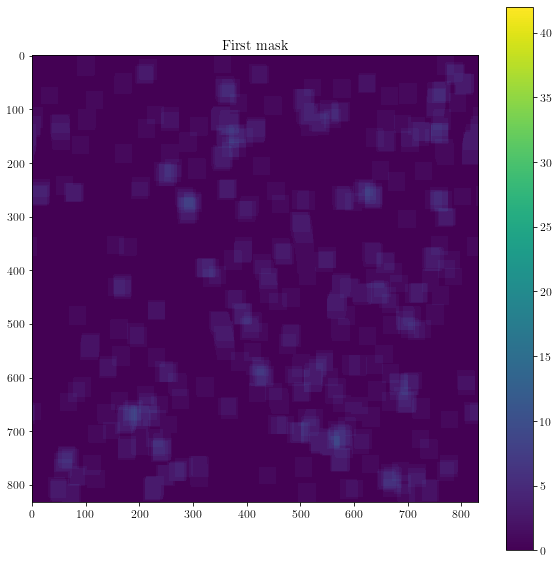

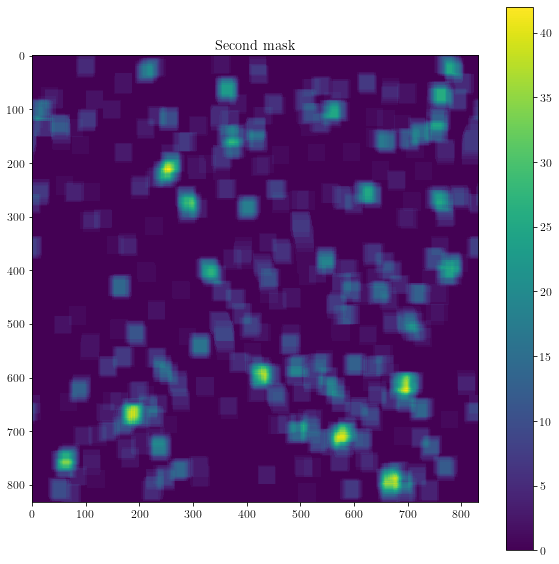

The first mask covers 39.87697623890533% of space-time
The second mask covers 49.32464057877219% of space-time
80.84595401201393 = intersection/union = overlap%


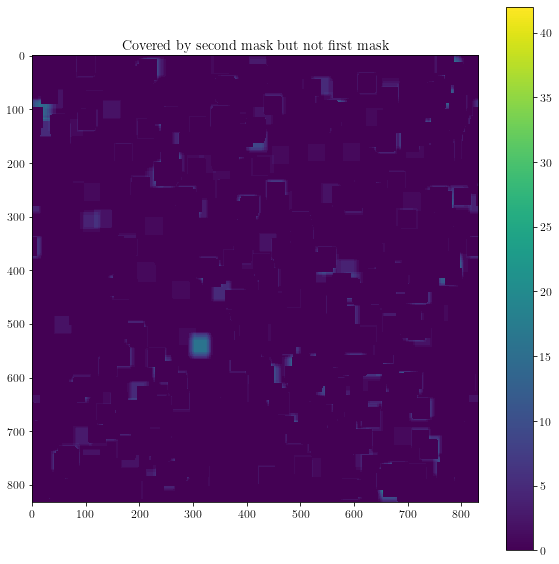

In [801]:
compare_cover_plot(minimal_covering_union, group_orbit_covering_union, figsize=(10,10), dtype=int)

The constituents or "factors" of the minimal cover of the cover resulting from the group orbit cover.

9.341918223002958% space-time covered by orbit 111


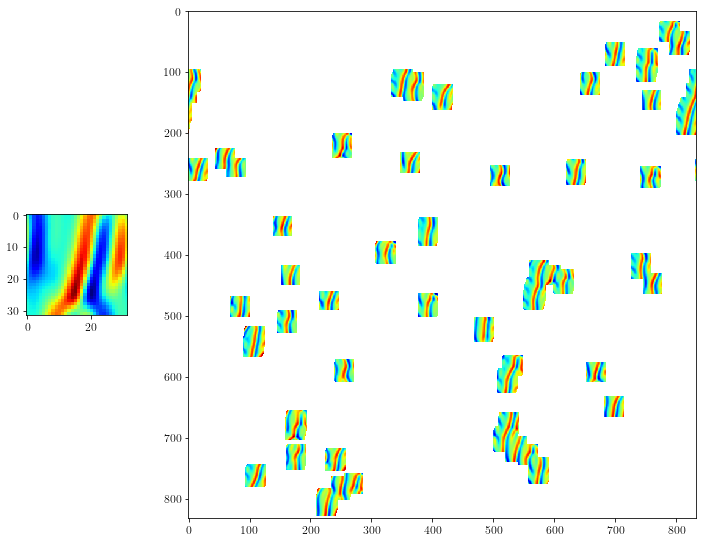

##############
7.805132442677515% space-time covered by orbit 41


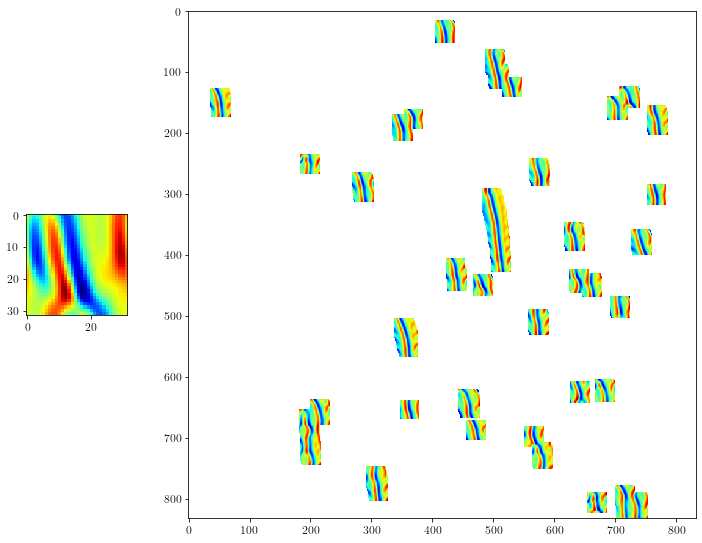

##############
5.557594073594674% space-time covered by orbit 8


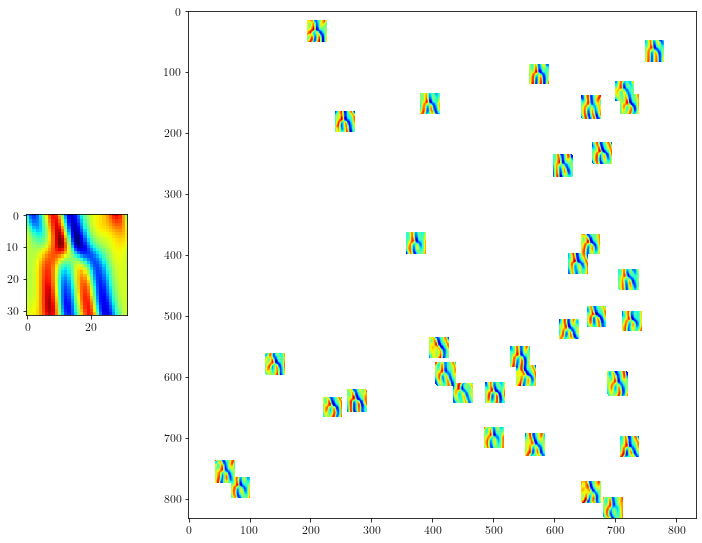

##############
5.477273252588757% space-time covered by orbit 18


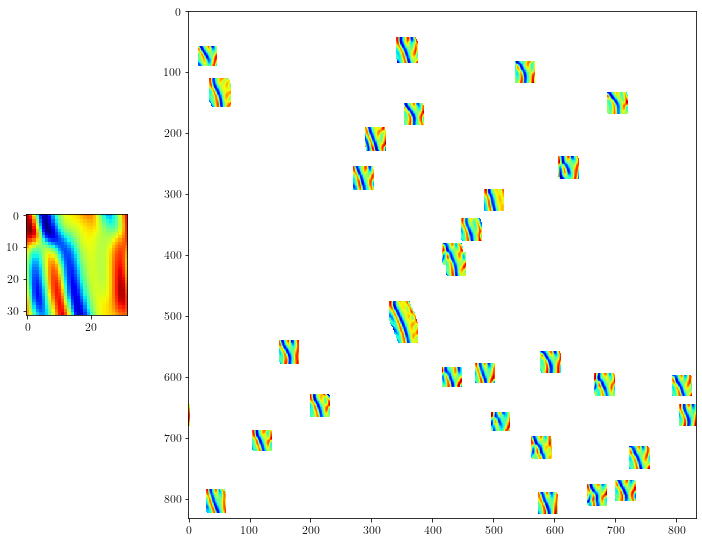

##############
6.374670626849112% space-time covered by orbit 42


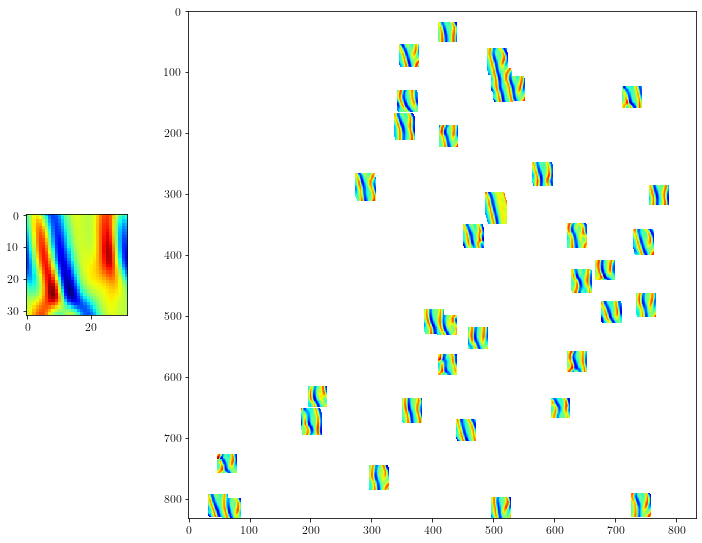

##############
3.6348060743343193% space-time covered by orbit 78


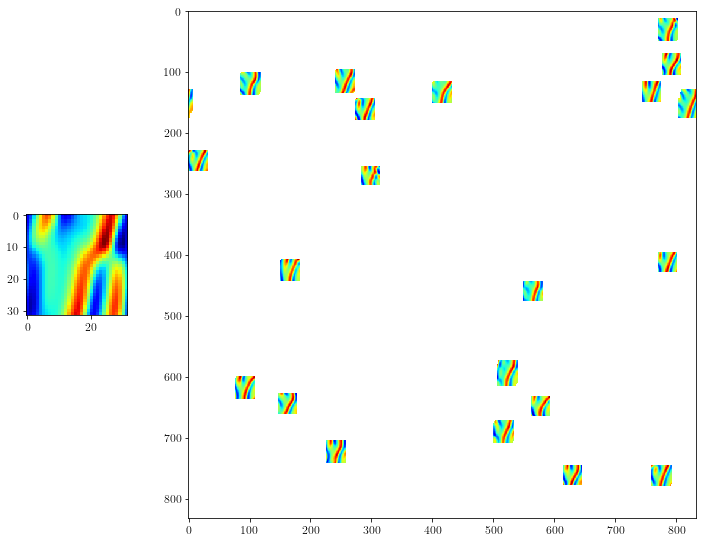

##############
4.1636811205621305% space-time covered by orbit 21


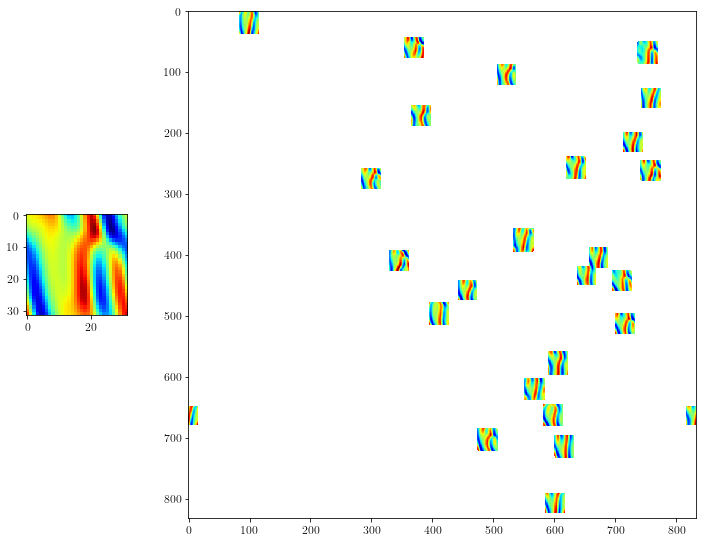

##############
5.88234444341716% space-time covered by orbit 110


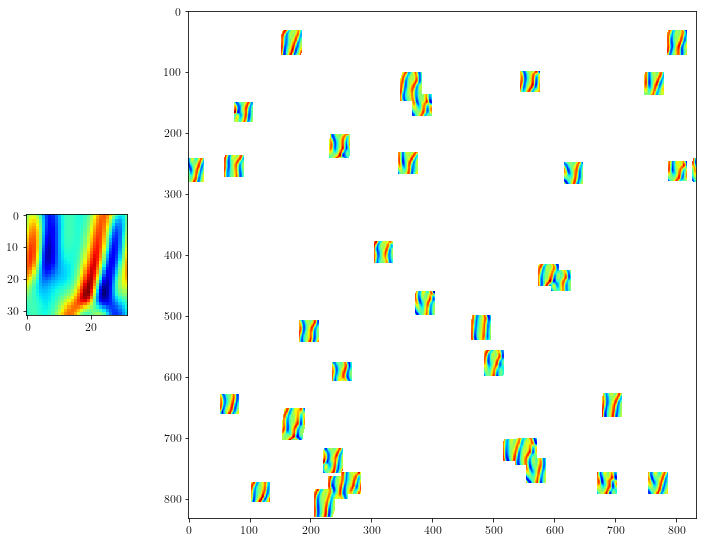

##############
2.612449149408284% space-time covered by orbit 81


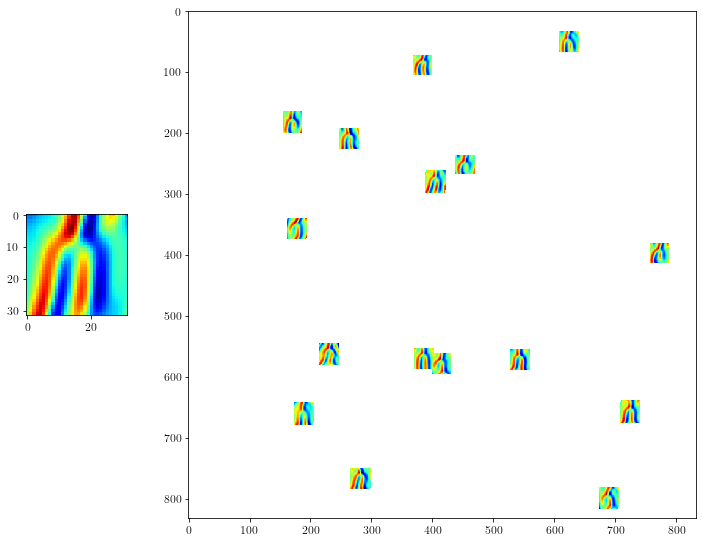

##############
3.635817307692308% space-time covered by orbit 92


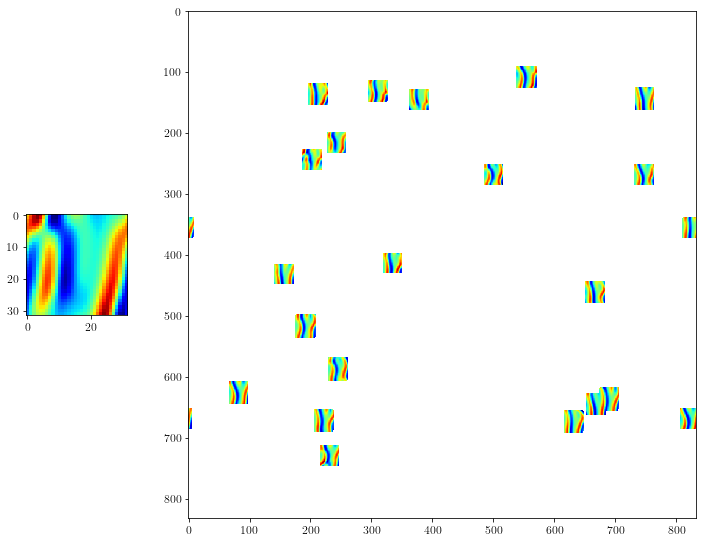

##############
3.2607941937869827% space-time covered by orbit 58


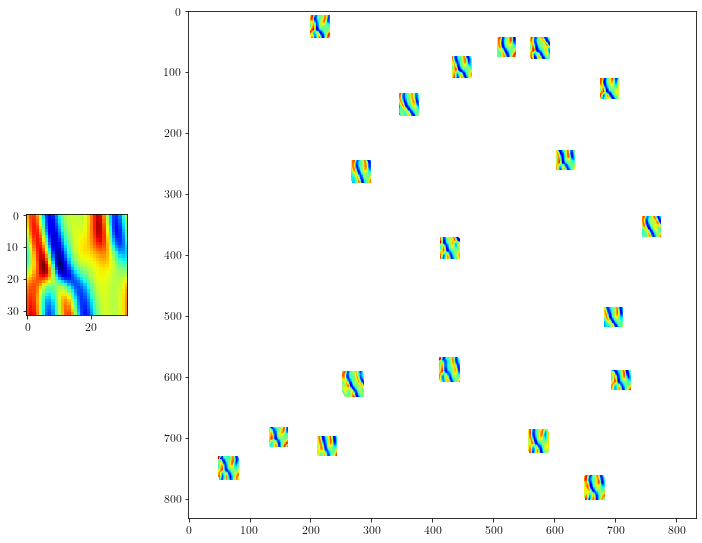

##############
4.491320728550296% space-time covered by orbit 35


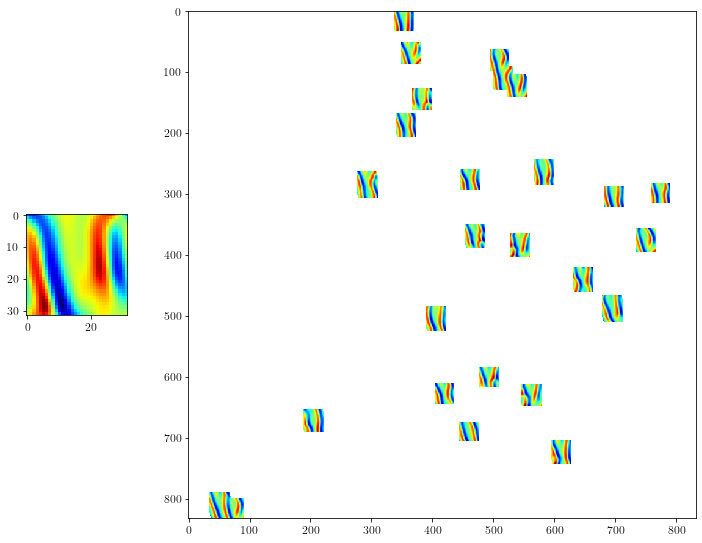

##############
3.2802965514053253% space-time covered by orbit 3


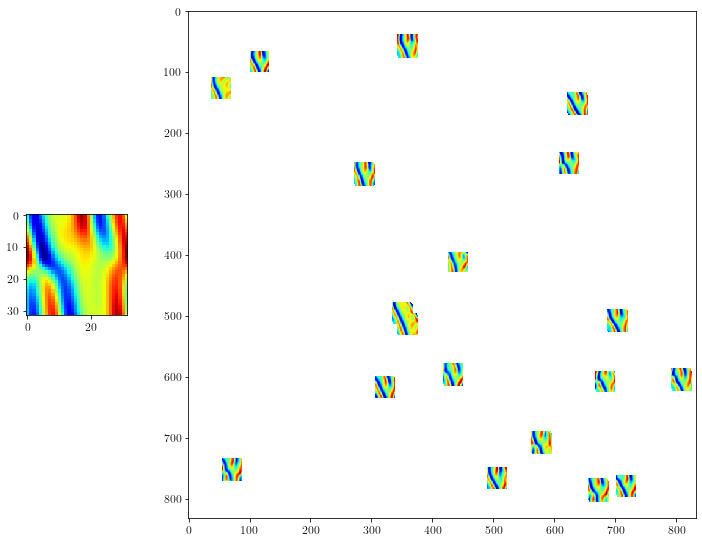

##############
7.880108173076923% space-time covered by orbit 103


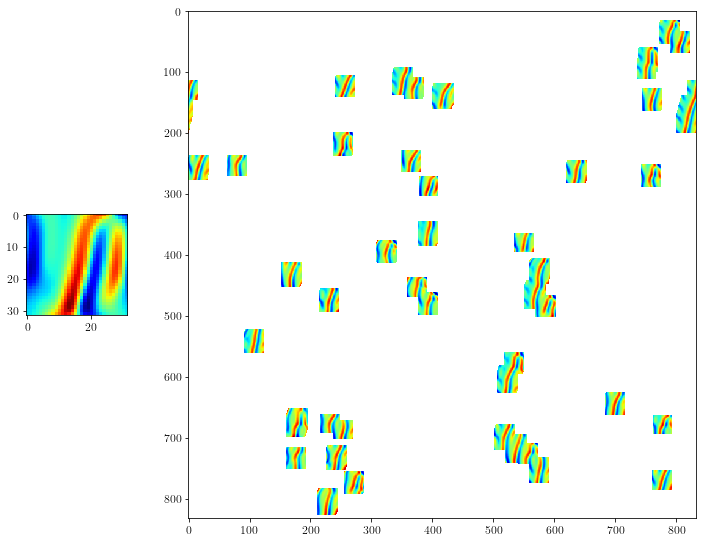

##############
3.666443232248521% space-time covered by orbit 23


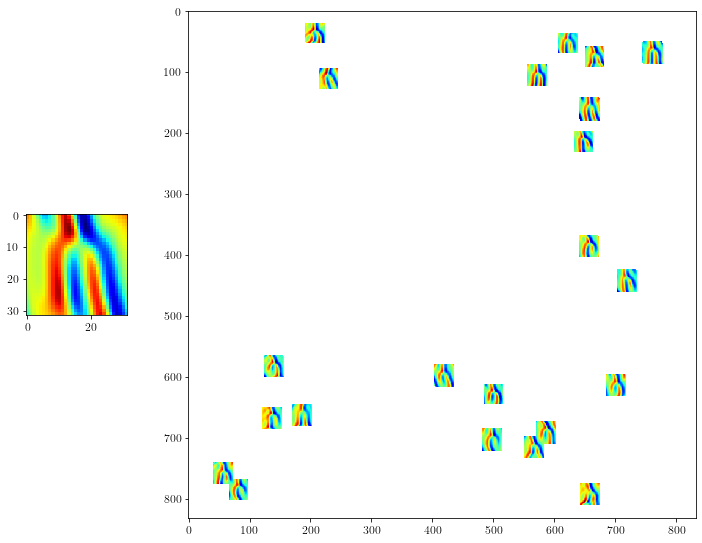

##############
1.9513914571005917% space-time covered by orbit 105


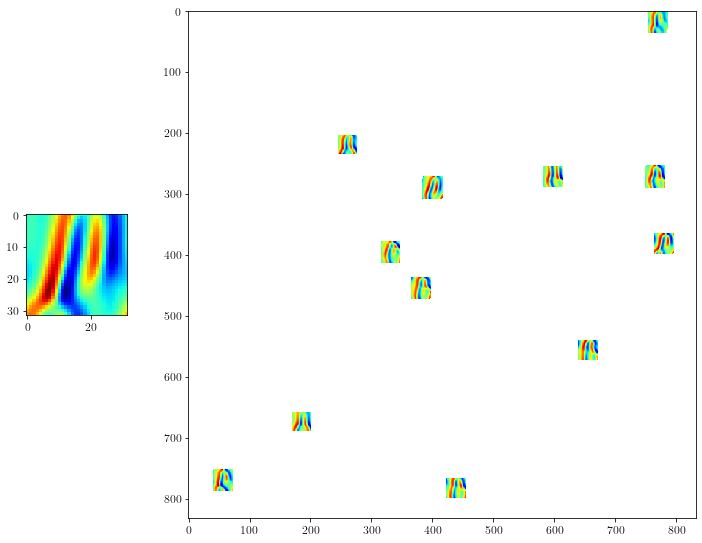

##############


In [802]:
plot_covering_factors(minimal_covering, large_patch, large_defect_group_orbit,
              strides=(1,1), verbose=True,  figsize=(12,12))

This minimal cover is comprised of 16 constituents; this is used as a guideline and so here on out, the translations used to produce the group orbit of each covering orbit yields 18 group orbit members.

[Return to table of contents](#toc)
<a id='minimal'></a>
# Full search using the previous results 

Now that we have some idea as to how many family and group orbit members we need for a covering, let's go full bore so that we may compare the overlaps between different families.

In [860]:
minimal_cover = read_h5('minimal_cover.h5')

strictness = 1
critical_values = []
with h5py.File('critical_values.h5', 'r') as file:
    critical_values.append(file['defect/l2_difference'][...][strictness])
    critical_values.append(file['drifter/l2_difference'][...][strictness])
    critical_values.append(file['large_defect/l2_difference'][...][strictness])
    critical_values.append(file['wiggle/l2_difference'][...][strictness])

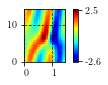

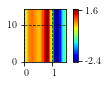

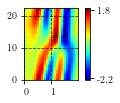

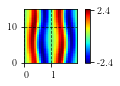

In [589]:
for orbit_ in minimal_cover:
    orbit_.plot()

For the first major computation, use the minimal covering consisting of the wiggle, defects of different sizes, and relative equilibrium or "drifter" solution. This computation will iterate over the families both in and out of the fundamental domains as it is not clear which is correct. These computations use the strictest thresholds, requiring scores to be in the bottom 0.01% of the L2 distance distributions in the previous notebooks. First, do not use the fundamental domains of each orbit. 

<a id='minimal1'></a>
#### 4.a Orbit covers with fundamental_domain==False

In [107]:
covers = []
cover_families
t0_full_cover = time.time_ns()/10**9
for root, l2_cval in zip(minimal_cover, critical_values):
    # actually single orbits, put into tuple to abide by requirements. 
    family = tuple(root.group_orbit(rolls=(12, 12), fundamental_domain=False))
    family_critical_values = tuple([l2_cval]*len(family))
    family_covering = cover(large_patch, family_critical_values, family,
                            score_type='pointwise',
                            scoring_function=l2_difference,
                            replacement=False,
                            base_orbit_periodicity=(False, True),
                            strides=(1,1),
                            verbose=False)
    cover_families.append(family)    
    covers.append(family_covering)

t1_full_cover = time.time_ns()/10**9

In [ ]:
# Reorganization of results for future computations; essentially merging the currently distinct coverings.
cover_orbits_collection = []
cover_collection = []
i = 0 
for c, root in zip(covers, minimal_cover):
    fam = tuple(root.group_orbit(rolls=(12, 12), fundamental_domain=False))
    for keys in c:
        entire_covering[i] = c[keys]
        covering_orbits.append(fam[keys])
        i += 1
    cover_orbits_collection.append(fam)
    cover_collection.append(c)
    

In [108]:
print('Group orbit covering took {:.2f} minutes to complete'.format((t1_full_cover-t0_full_cover)/(60)))

Group orbit covering took 51.18 minutes to complete


[Return to table of contents](#toc)
### Visualize these covers and the factors that contribute to their minimal subsets.
This requires many plots: [skip to the next computation](#skip1). For each family, the plots of
the minimal covering and its comparison to the full cover are provided, followed by the factors in the
minimal covering and their contributions.

Minimal cover of the defect family and its factors


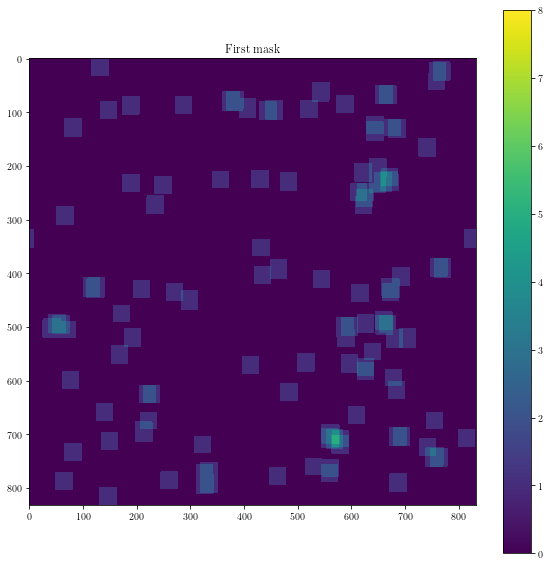

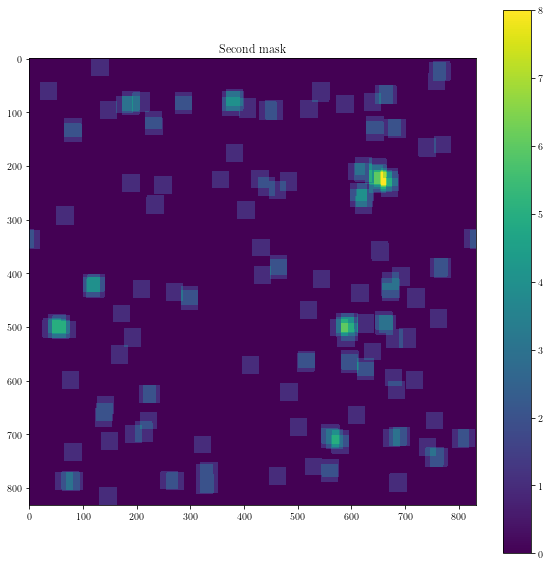

The first mask covers 14.37526003143491% of space-time
The second mask covers 17.778782590606507% of space-time
80.85626762222819 = intersection/union = overlap%


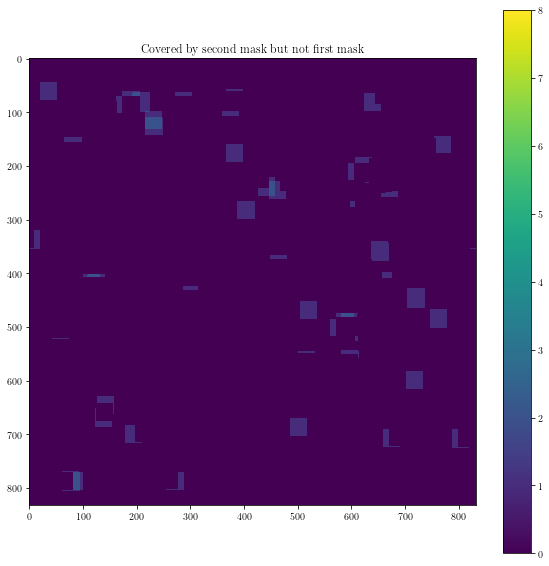

2.8050168731508873% space-time covered by orbit 0


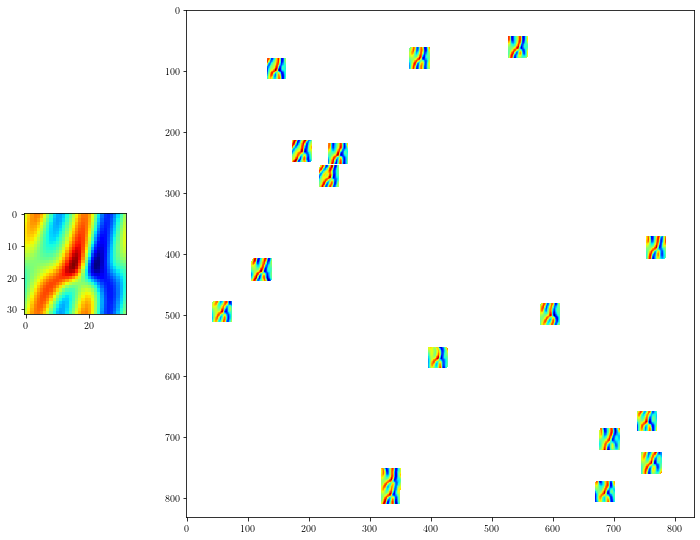

##############
2.40586862056213% space-time covered by orbit 9


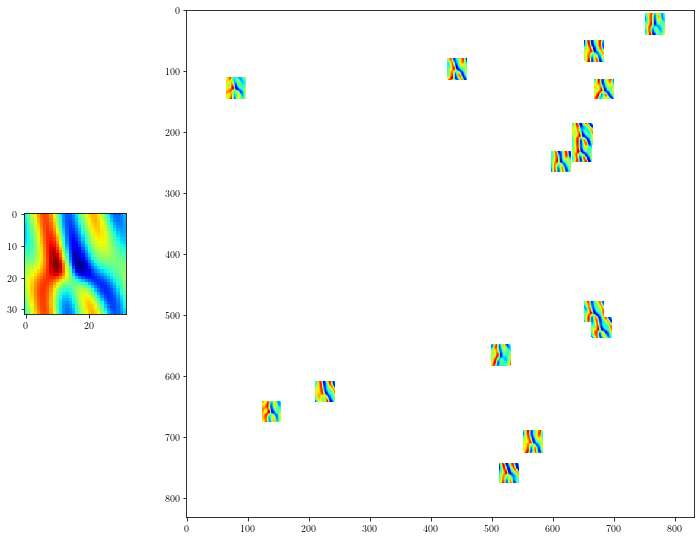

##############
2.368308524408284% space-time covered by orbit 10


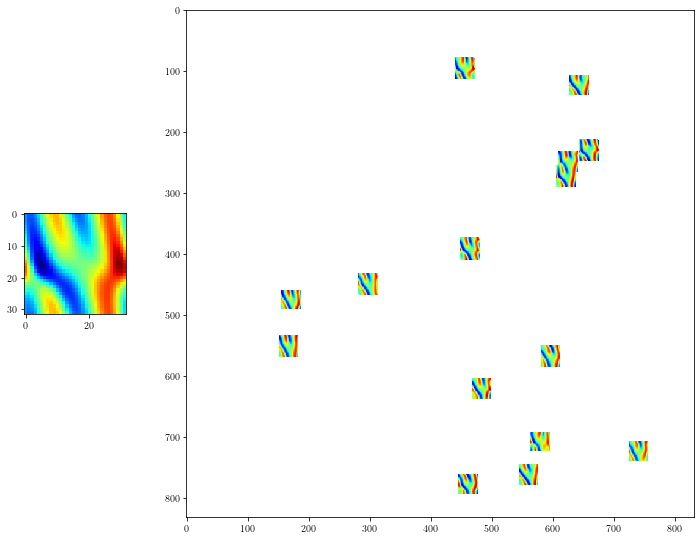

##############
2.016254853920118% space-time covered by orbit 4


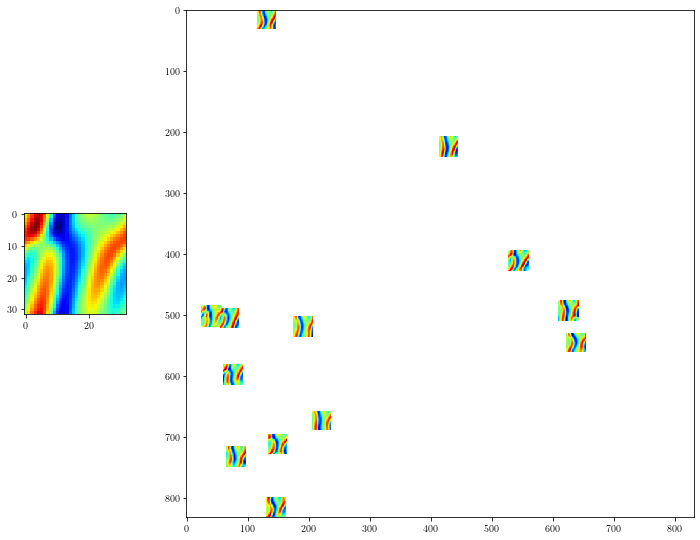

##############
2.210267196745562% space-time covered by orbit 11


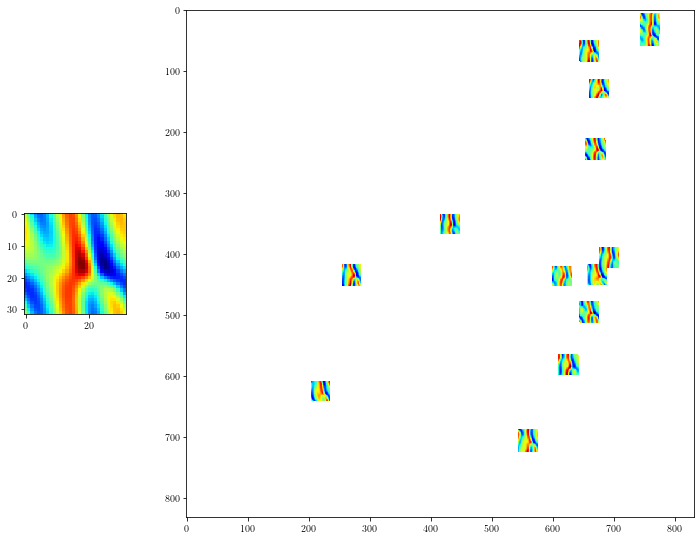

##############
2.3937338202662723% space-time covered by orbit 2


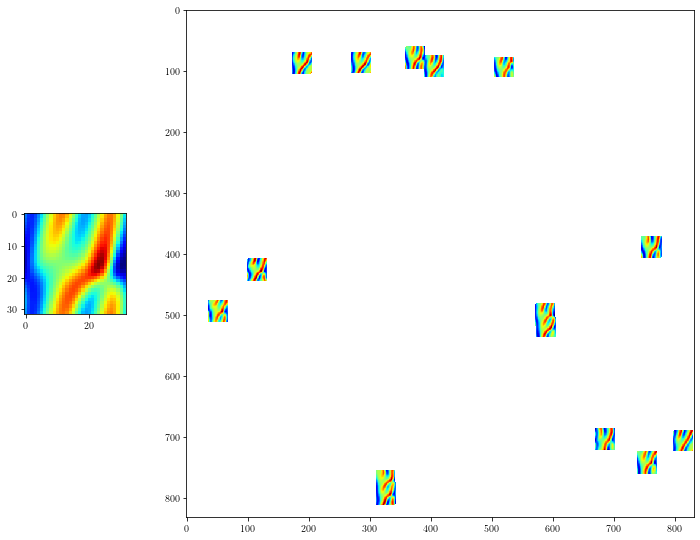

##############
1.604538415310651% space-time covered by orbit 13


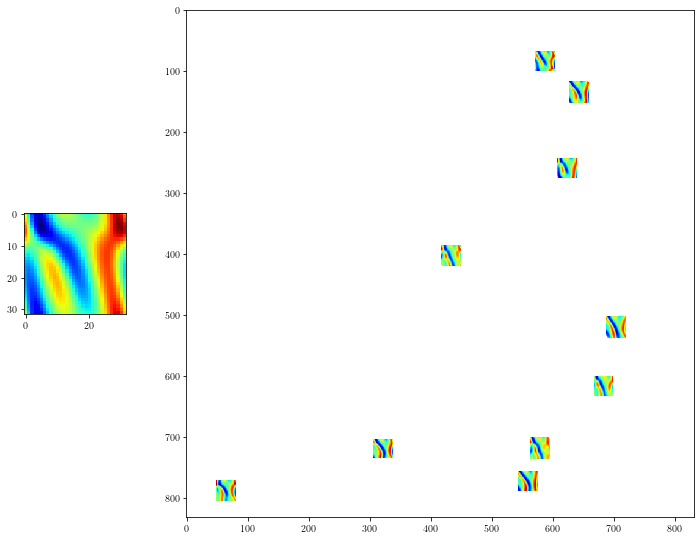

##############
0.9427584134615384% space-time covered by orbit 7


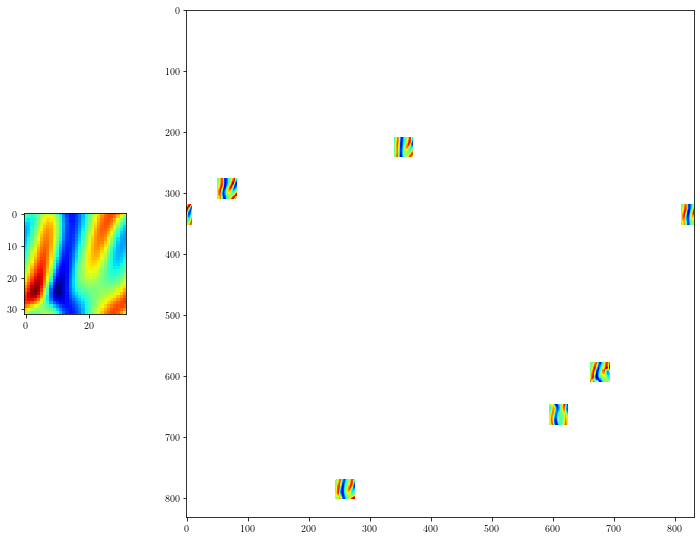

##############
1.684425850591716% space-time covered by orbit 17


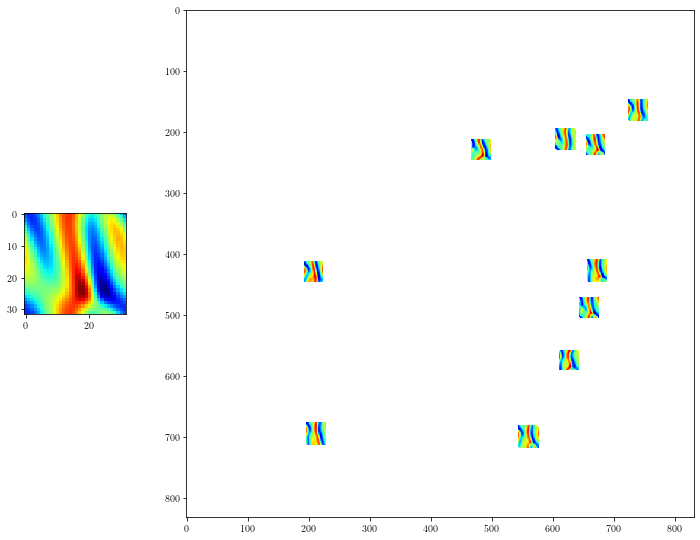

##############
Minimal cover of the drifter family and its factors


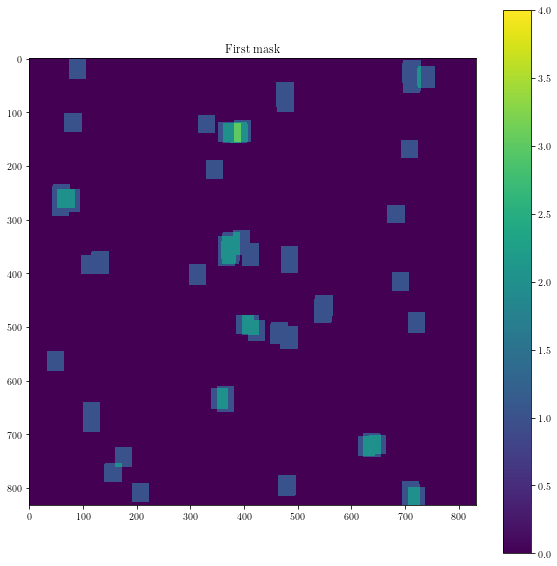

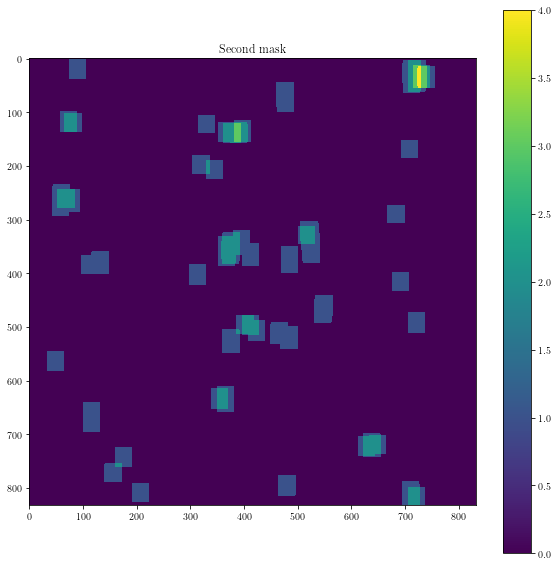

The first mask covers 7.074010724852071% of space-time
The second mask covers 7.9299475314349115% of space-time
89.20627402401034 = intersection/union = overlap%


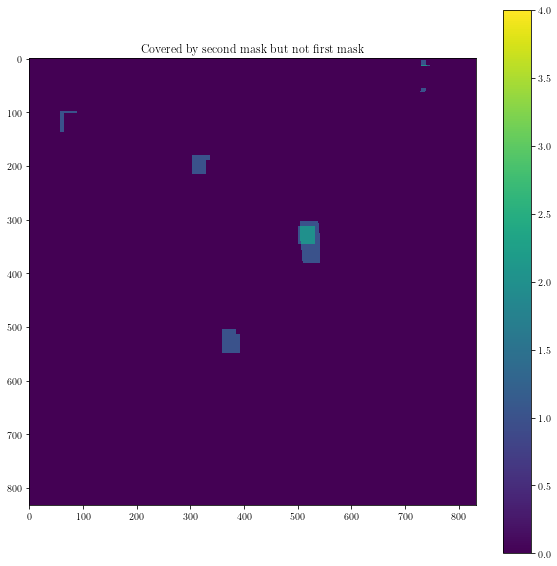

3.758465467825444% space-time covered by orbit 17


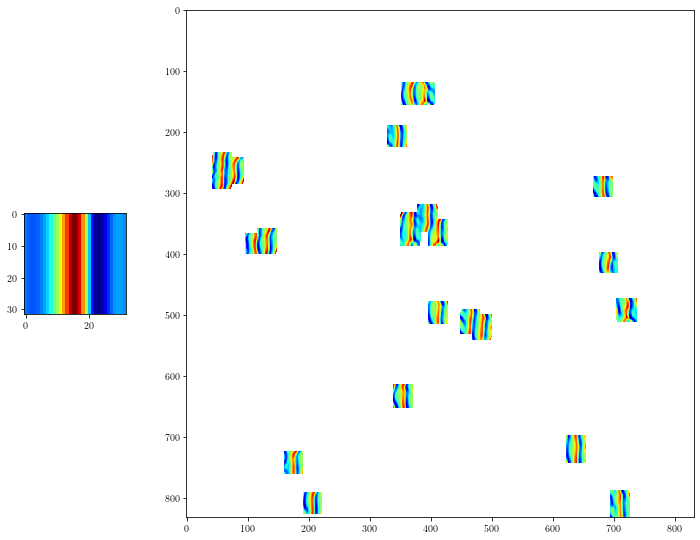

##############
2.105676775147929% space-time covered by orbit 9


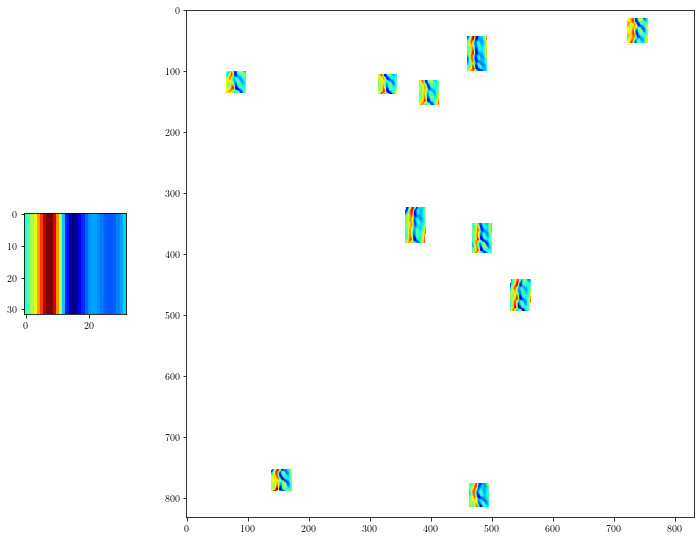

##############
2.5676659578402363% space-time covered by orbit 1


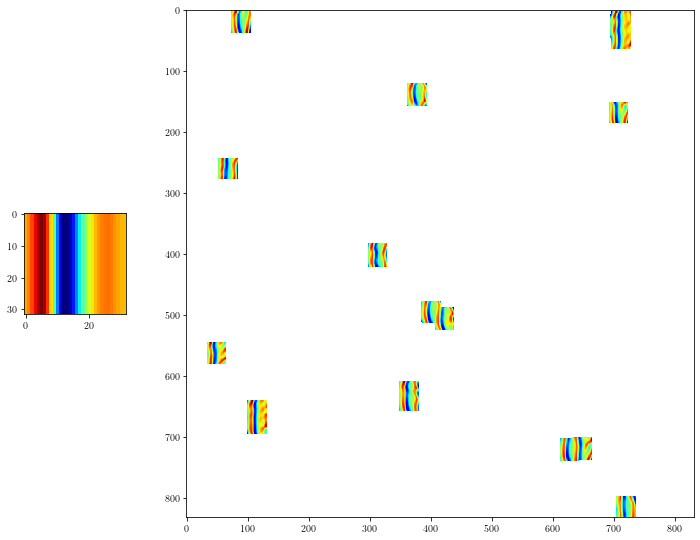

##############
Minimal cover of the large_defect family and its factors


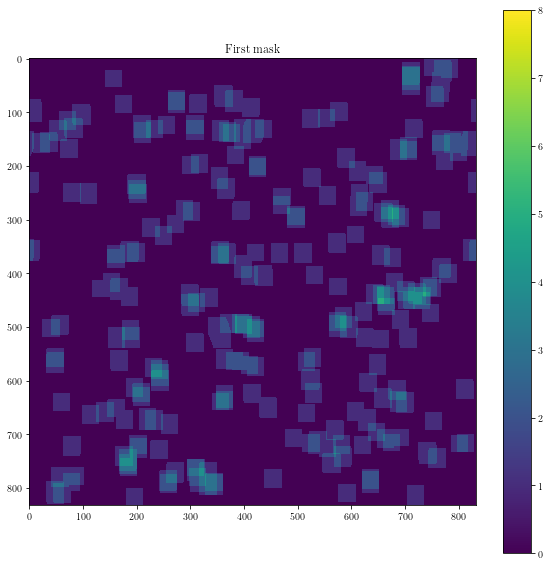

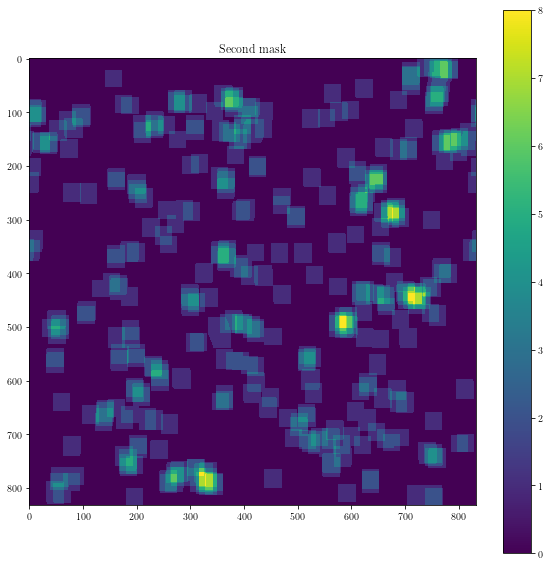

The first mask covers 29.879489876109467% of space-time
The second mask covers 35.598158977440825% of space-time
83.935491987225 = intersection/union = overlap%


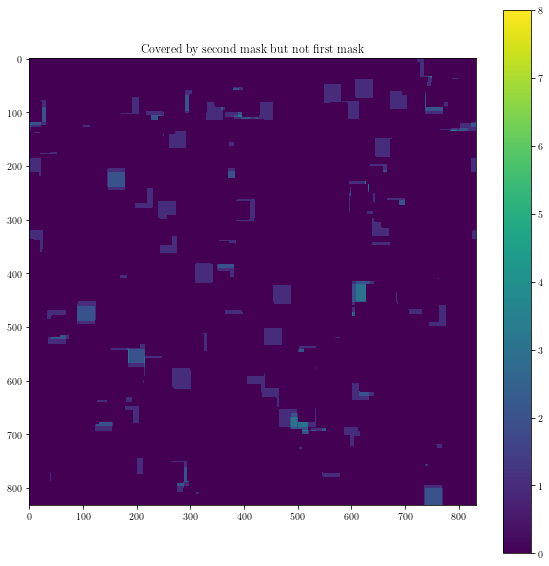

6.731924926035503% space-time covered by orbit 1


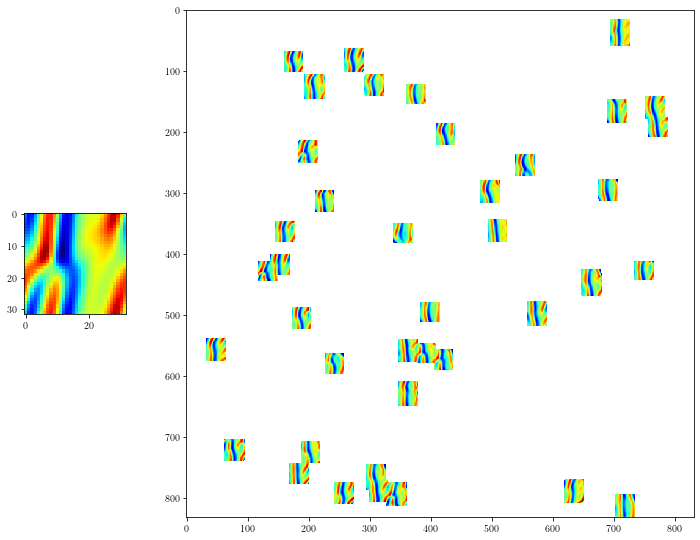

##############
4.744706915680473% space-time covered by orbit 9


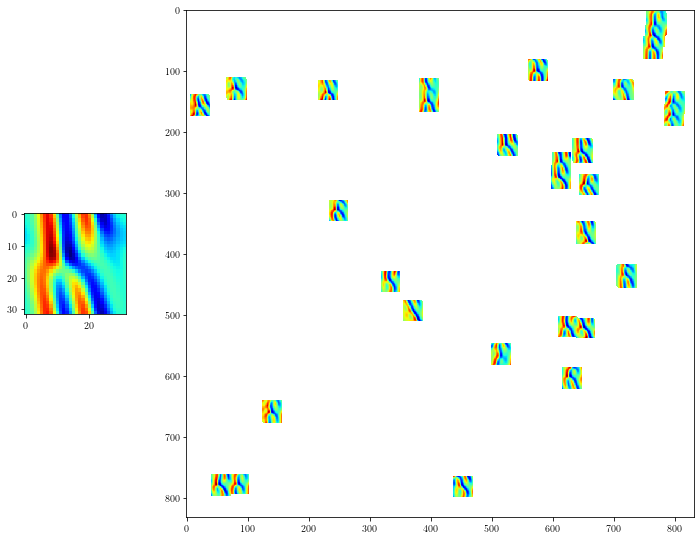

##############
4.607612564718934% space-time covered by orbit 13


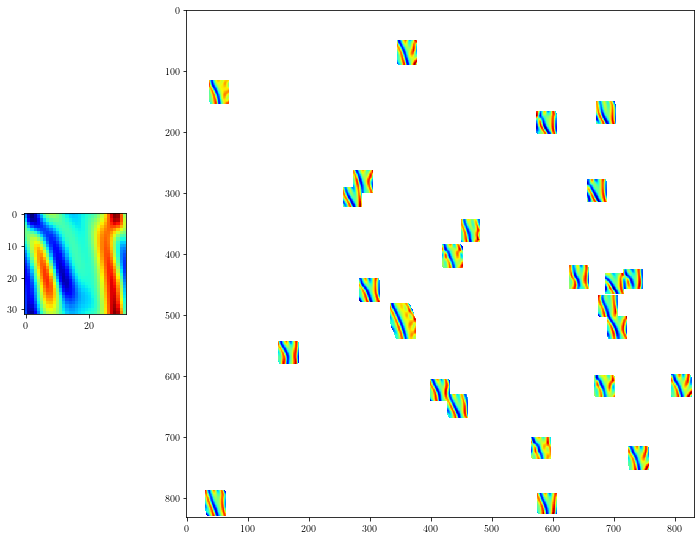

##############
5.783099112426036% space-time covered by orbit 4


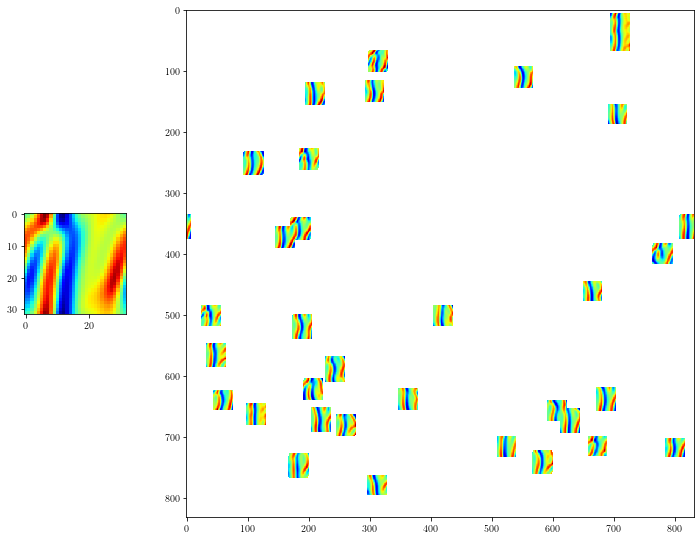

##############
4.265382303994083% space-time covered by orbit 5


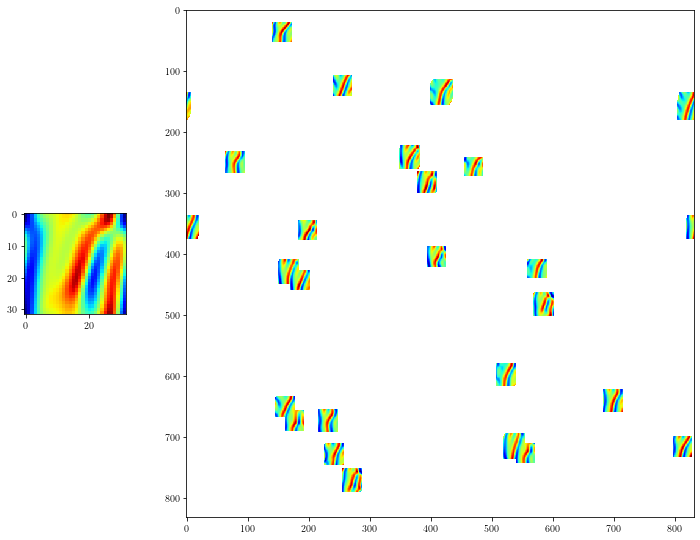

##############
4.5202131102071% space-time covered by orbit 14


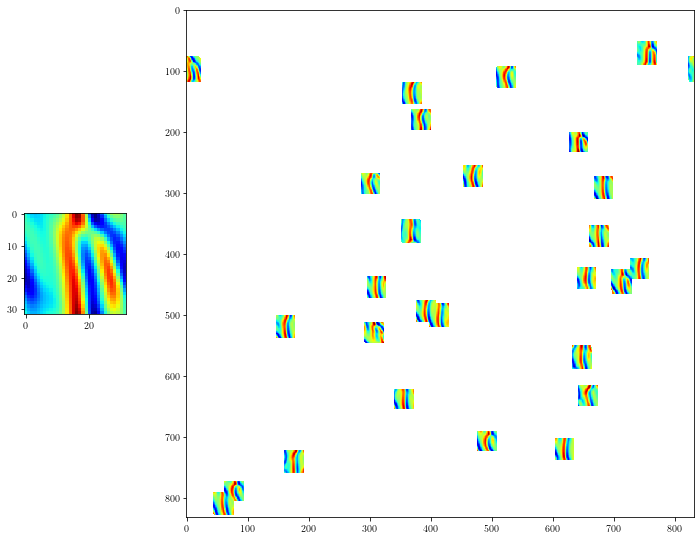

##############
3.8007928069526624% space-time covered by orbit 0


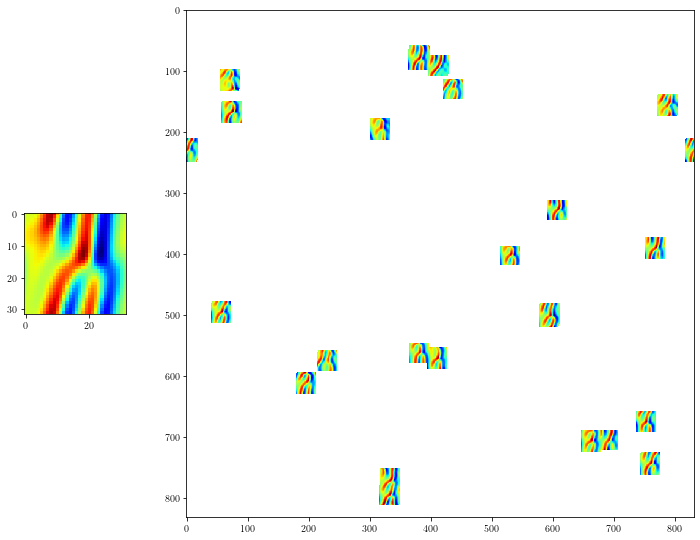

##############
2.872769508136095% space-time covered by orbit 16


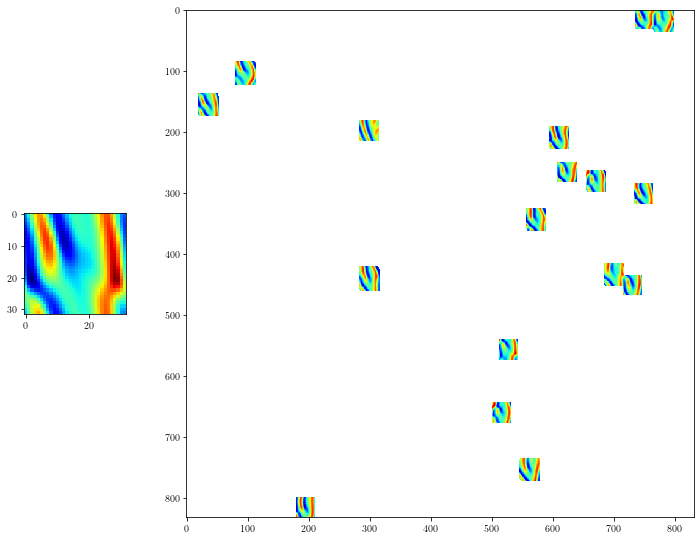

##############
4.900436852810651% space-time covered by orbit 7


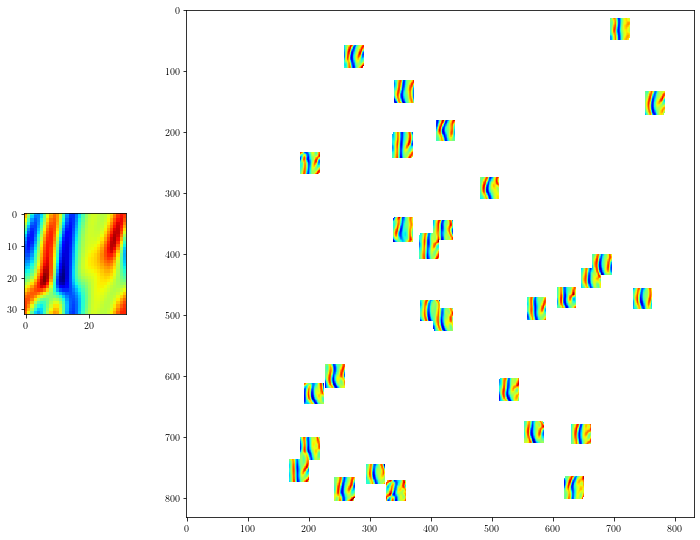

##############
Minimal cover of the wiggle family and its factors


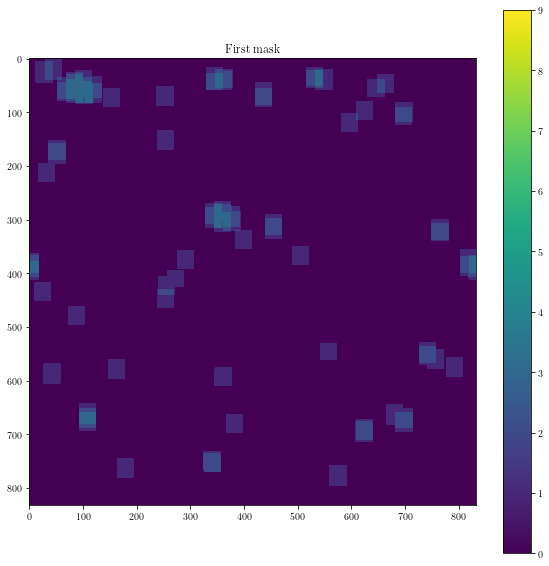

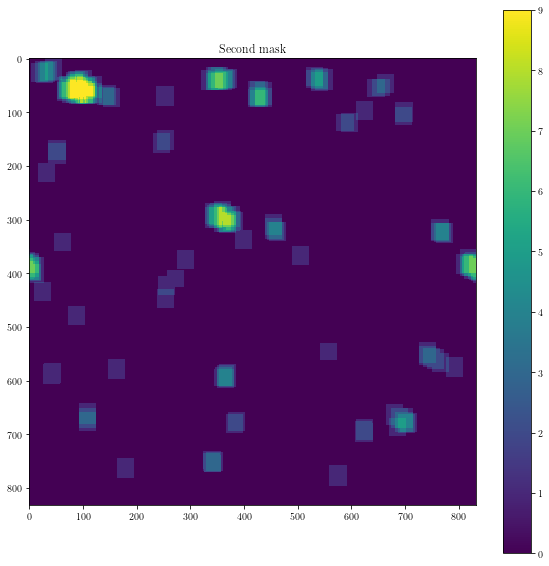

The first mask covers 8.512417945636095% of space-time
The second mask covers 9.65540056397929% of space-time
88.16224546284244 = intersection/union = overlap%


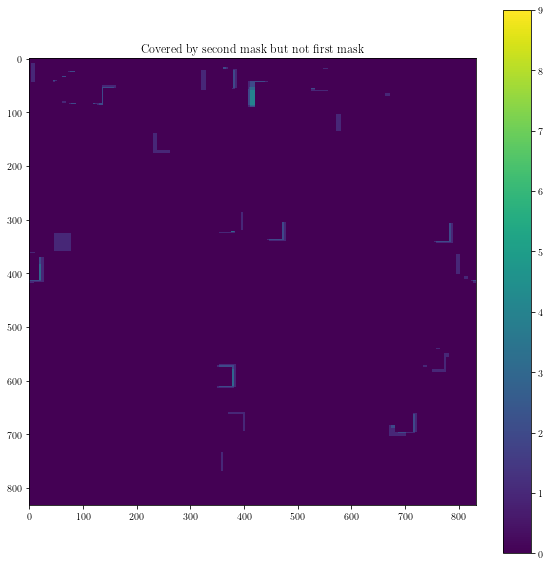

4.971223187869823% space-time covered by orbit 2


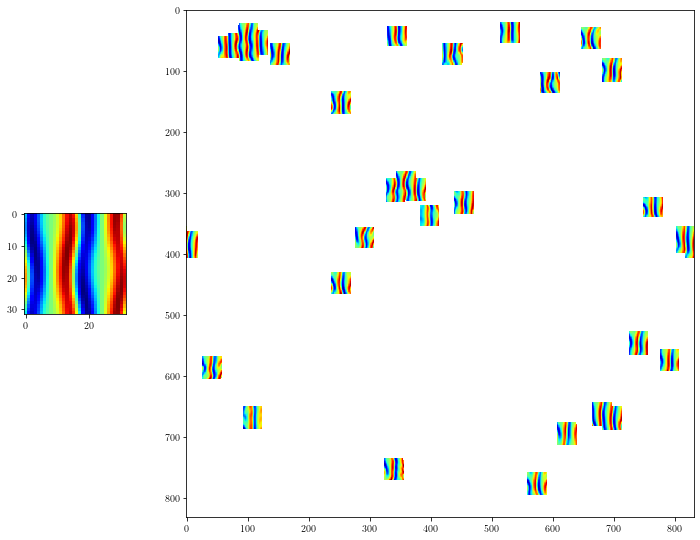

##############
4.394242326183432% space-time covered by orbit 17


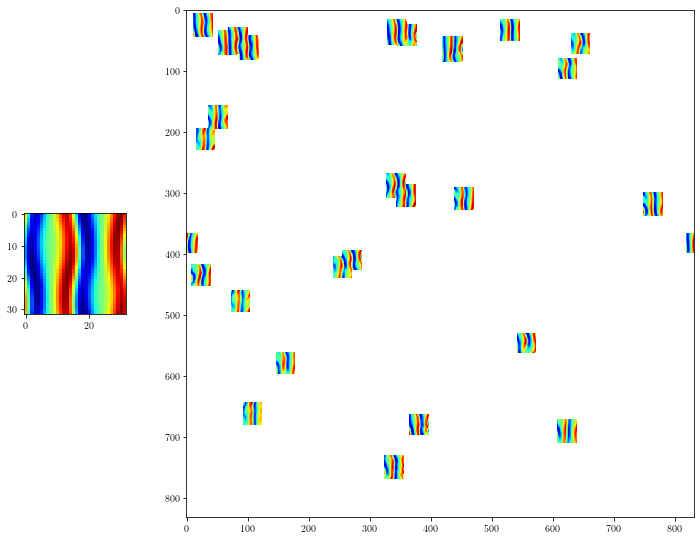

##############
3.2082100591715976% space-time covered by orbit 5


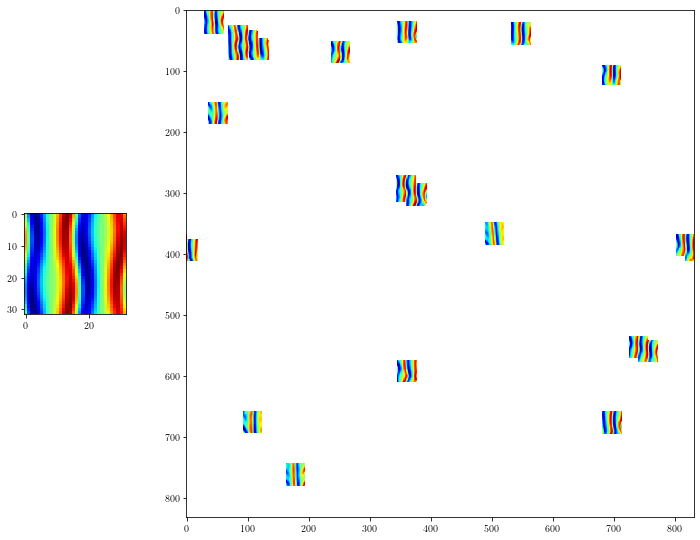

##############


In [785]:
labels = ['defect', 'drifter', 'large_defect', 'wiggle']

all_families_cover = {}
for i, (family_cover, family) in enumerate(zip(covers, cover_families)):
    print('Minimal cover of the {} family and its factors'.format(labels[i]))
    cover_threshold=0.8
    family_critical_values = tuple([l2_cval]*len(family))
    
    minimal_covering, minimal_covering_union, _ = minimal_covering_set(family_cover, large_patch,
                                                                       family, cover_threshold,
                                                                       strides=(1,1), verbose=False)

    family_cover_union = covering_union(family_cover, large_patch,
                                                   family, strides, dtype=int)
    all_families_cover[i] = family_cover_union
    compare_cover_plot(minimal_covering_union, family_cover_union, figsize=(10,10), dtype=int)

    plot_covering_factors(minimal_covering, large_patch, family,
                  strides=(1,1), verbose=True, figsize=(12,12))  
    


<a id='minimal2'></a>
#### 4.b Orbit covers with fundamental_domain==True
<a id='skip1'></a>

In [857]:
strictness = 0
critical_values_fd = []
with h5py.File('critical_values.h5', 'r') as file:
    critical_values_fd.append(file['defect/l2_difference_fundamental_domain'][...][strictness])
    critical_values_fd.append(file['drifter/l2_difference_fundamental_domain'][...][strictness])
    critical_values_fd.append(file['large_defect/l2_difference_fundamental_domain'][...][strictness])
    critical_values_fd.append(file['wiggle/l2_difference_fundamental_domain'][...][strictness])


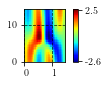

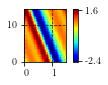

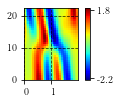

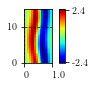

In [803]:
for orbit in minimal_cover:
    orbit.plot(fundamental_domain=True)

#### Only run this next cell if covers have not been saved. 

In [1]:
# covers_fd = []
# cover_fd_families = []
# t0_full_cover_fd = time.time_ns()/10**9
# for root, l2_cval_fd in zip(minimal_cover, critical_values_fd):
#     # actually single orbits, put into tuple to abide by requirements. 
#     family_fd = tuple(root.group_orbit(rolls=(12, 12), fundamental_domain=True))
#     family_fd_critical_values = tuple([l2_cval_fd]*len(family_fd))
#     family_fd_covering = cover(large_patch, family_fd_critical_values, family_fd,
#                                 score_type='pointwise',
#                                 scoring_function=l2_difference,
#                                 replacement=False,
#                                 base_orbit_periodicity=(False, True),
#                                 strides=(1,1),
#                                 verbose=False)
#     cover_fd_families.append(family_fd)
#     covers_fd.append(family_fd_covering)

# t1_full_cover_fd = time.time_ns()/10**9

# labels = ['defect_fd', 'drifter_fd', 'large_defect_fd', 'wiggle_fd']
# for lab, fam, cov in zip(labels, cover_fd_families, covers_fd):
#     covering_union(cov, large_patch, fam, (1, 1),
#                filename='large_patch_complete_covering.h5', groupname=lab, dtype=int)

In [ ]:
# reorganization for future computations; ignore. 
entire_covering = {}
covering_orbits = []
i = 0 
for c, fam in zip(covers_fd, cover_fd_families):
    for keys in c:
        entire_covering_fd[i] = c[keys]
        covering_fd_orbits.append(fam[keys])
        i += 1
    cover_orbits_collection.append(fam)
    cover_collection.append(c)

[Return to table of contents](#toc)
<a id='skip1'></a>
### Visualize these covers and the factors that contribute to their minimal subsets.
This requires many plots: [skip to the next computation](#skip2). For each family, the plots of
the minimal covering and its comparison to the full cover are provided, followed by the factors in the
minimal covering and their contributions.

#### Each family separately
Excluded because it is similar to before and just clutters the already cluttered notebook.

In [804]:
# for i, (family_cover_fd, family_fd) in enumerate(zip(covers_fd, cover_fd_families)):
#     cover_threshold=0.8
#     minimal_covering_fd, minimal_covering_union_fd, _ = minimal_covering_set(family_cover_fd, large_patch,
#                                                                        family_fd, cover_threshold,
#                                                                        strides=(1,1), verbose=False)

#     family_cover_union_fd = covering_union(family_cover_fd, large_patch,
#                                                    family_fd, strides, dtype=int)
#     compare_cover_plot(minimal_covering_union_fd, family_cover_union_fd, figsize=(10,10), dtype=int)
#     plot_covering_factors(minimal_covering_fd, large_patch, family_fd,
#                           strides=(1,1), verbose=True,  figsize=(12,12))  
#     all_families_cover[i+4] = family_cover_union_fd

#### All families

In [805]:
cover_threshold = 0.8
minimal_covering_fd, minimal_covering_fd_union, _ = minimal_covering_set(entire_covering_fd, large_patch,
                                                                   covering_fd_orbits, cover_threshold,
                                                                   strides=(1,1), verbose=False)

entire_covering_fd_union = covering_union(entire_covering_fd, large_patch,
                                          covering_fd_orbits, strides, dtype=int)

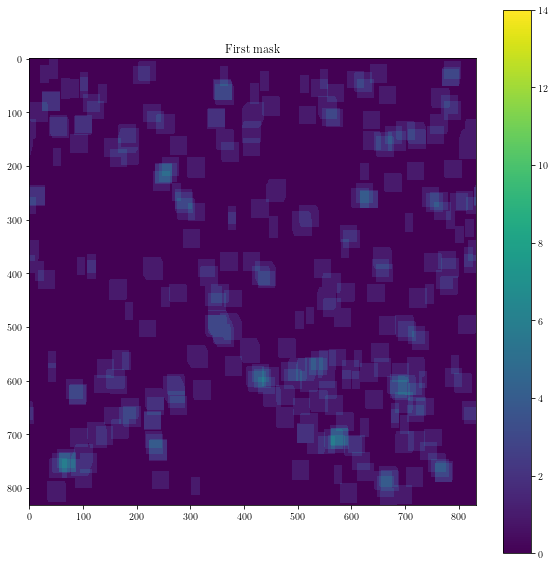

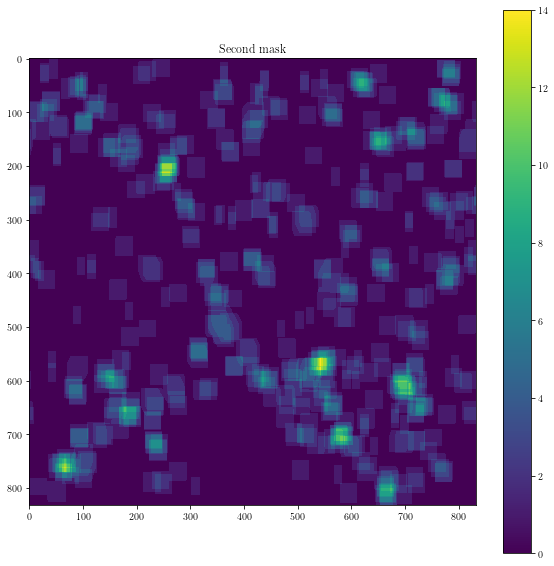

The first mask covers 33.14967409393491% of space-time
The second mask covers 40.633089866863905% of space-time
81.58295173355329 = intersection/union = overlap%


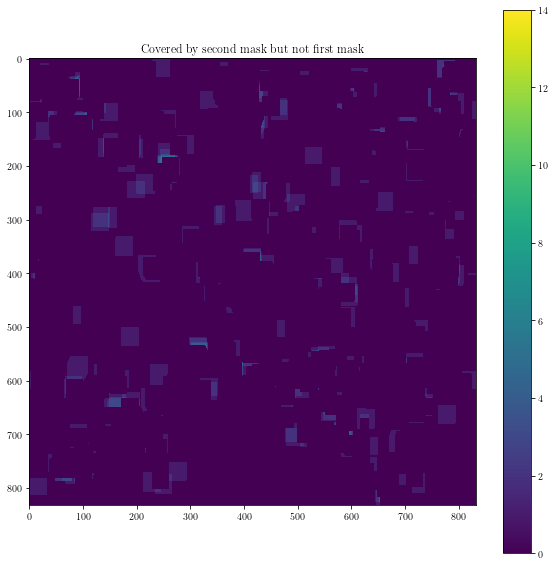

In [806]:
compare_cover_plot(minimal_covering_fd_union, entire_covering_fd_union, figsize=(10,10), dtype=int)

<a id='skip2'></a>
#### Combined results
Now finally look at the combination of all results up until this point; this computation does not look
at the differences or relationships between families

In [240]:
total_cover = {i:m for i, m in enumerate(list(entire_covering_fd.values())+list(entire_covering.values()))}
total_covering_orbits = covering_orbits + covering_fd_orbits

total_cover_threshold = 0.8
minimal_total_covering, minimal_total_covering_union, _ = minimal_covering_set(total_cover, large_patch,
                                                                   total_covering_orbits, total_cover_threshold,
                                                                   strides=(1,1), verbose=False)


Compare the minimal cover with the total cover; note that by definition the overlap percentage will be approximately 80%. 

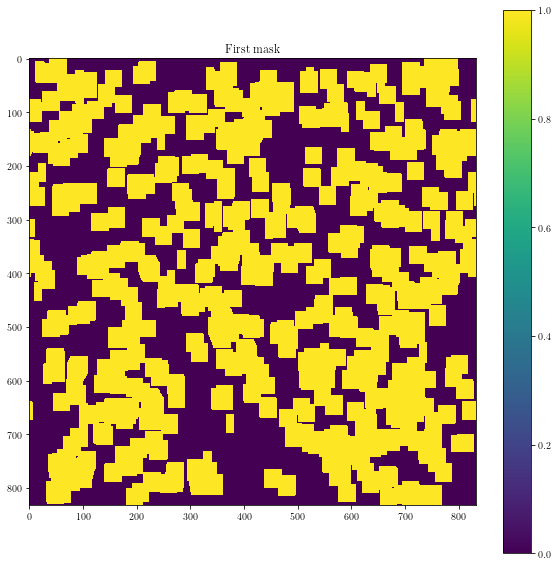

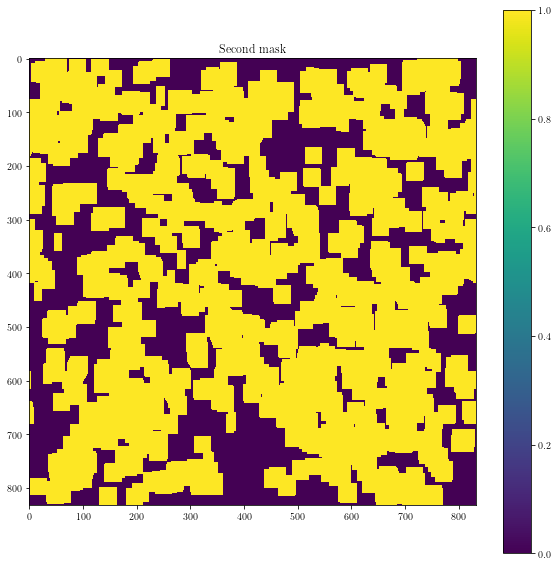

The first mask covers 54.558784439718934% of space-time
The second mask covers 67.42759569156804% of space-time
80.91462238885913 = intersection/union = overlap%


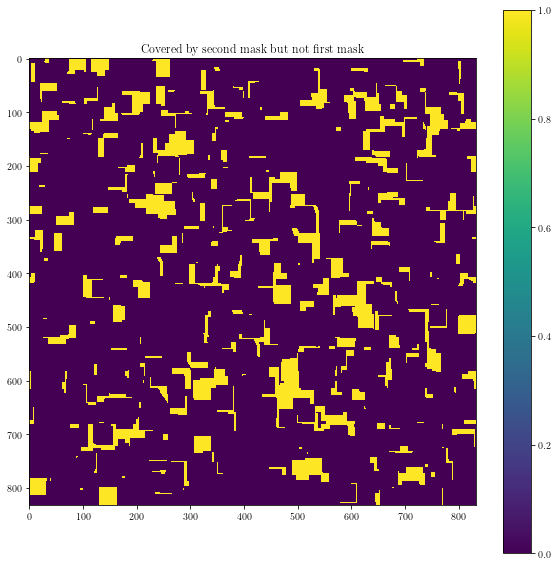

In [821]:
compare_cover_plot(minimal_total_covering_union,
                   covering_union(total_cover,
                                  large_patch,
                                  total_covering_orbits),
                   figsize=(10,10), dtype=bool)

Which yields the following as the 'final' result, which is plots of the original patch, the remainder after covering, and the covering, respectively.

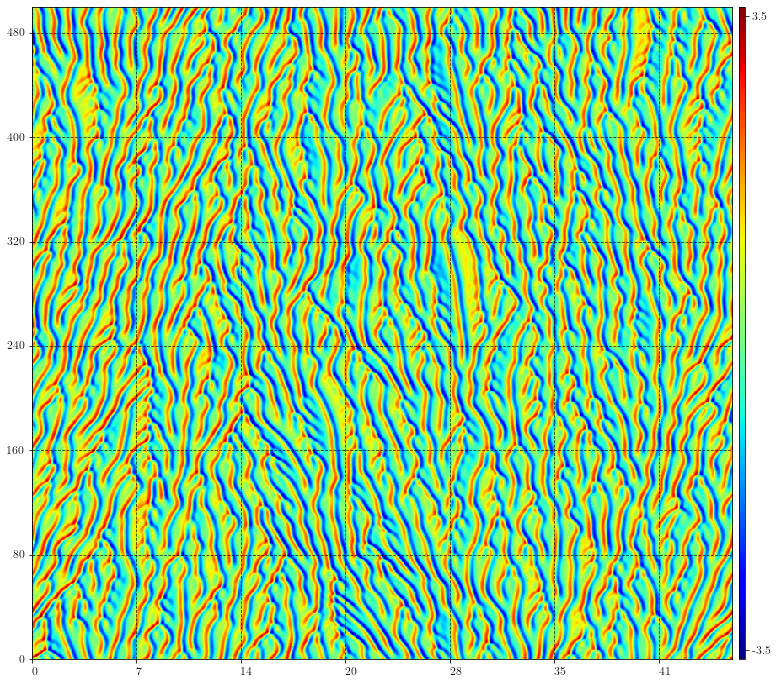

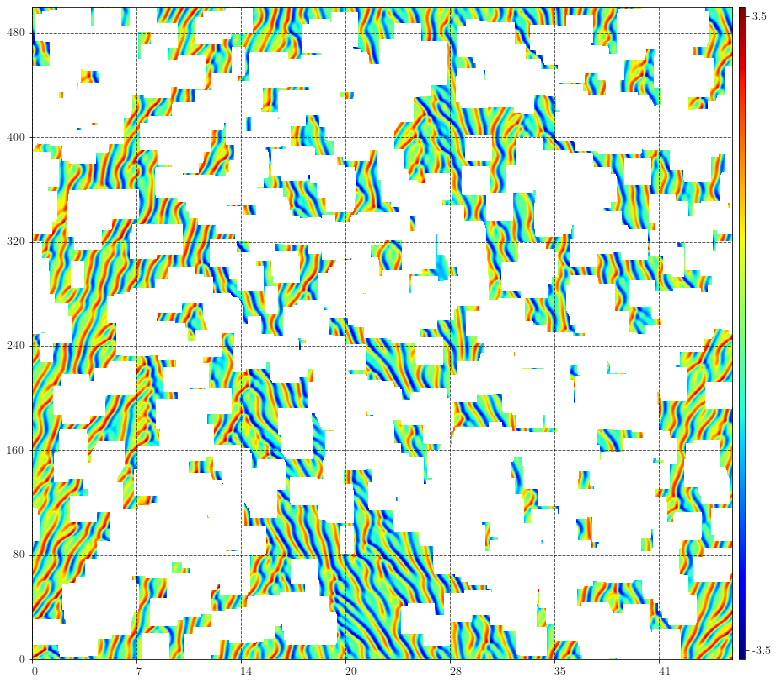

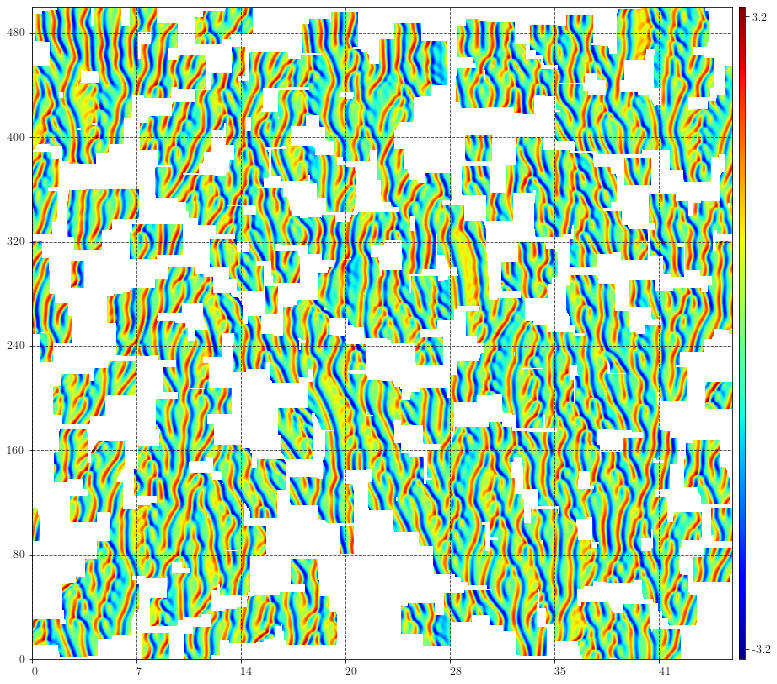

In [797]:
plot_covering_union(minimal_total_covering, large_patch, total_covering_orbits,
                    strides=(1,1), verbose=True, figsize=(12,12))  

## 5. Current difficulties
<a id='results'></a>

It's clear from the previous plot that the entirety of space-time is not being covered. Even if the threshold on the $L_2$ distance was more lax I do not think these regions would be captured even then. 

The two main issues right now:

1. Overlap between different families
2. Drifting regions. 
3. Patterns not in cover
How much overlap is there between all of the masks? This is what determines whether or not the $L_2$ difference is a sufficient metric; if space-time is being misclassified as shadowing multiple (fundamentally different) families, then we are in trouble.

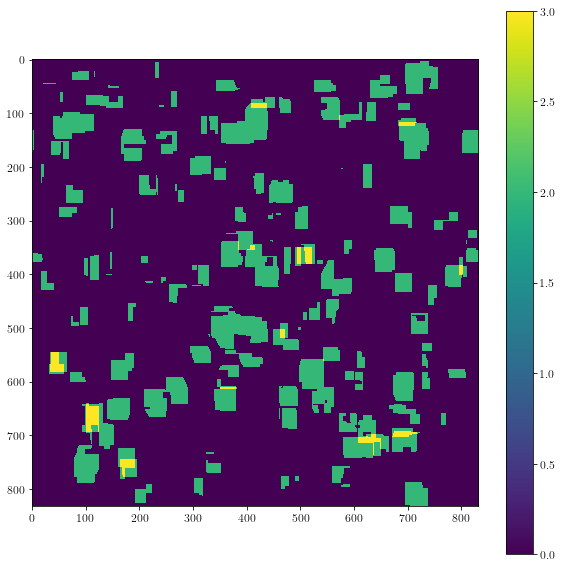

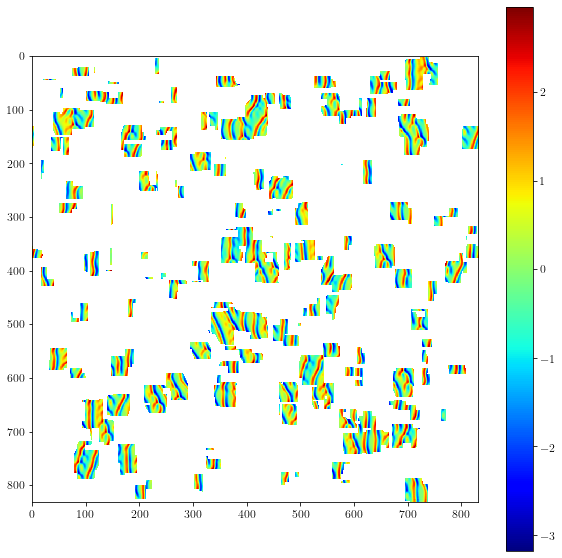

In [798]:
covering_summation = []
for i, (cover, orbits) in enumerate(zip(cover_collection, cover_orbits_collection)):
    if covering_summation is None:
        covering_summation.append(covering_union(cover, large_patch, orbits, dtype=bool).astype(int))
    else:
        covering_summation.append(covering_union(cover, large_patch, orbits, dtype=bool).astype(int))

defect_covers = np.sum(np.array(covering_summation)[[0,2,4,6]], axis=0).astype(bool).astype(int)
drifter_covers = np.sum(np.array(covering_summation)[[1, 5]], axis=0).astype(bool).astype(int)
wiggle_covers = np.sum(np.array(covering_summation)[[3, 7]], axis=0).astype(bool).astype(int)


overlap_summed = defect_covers + wiggle_covers + drifter_covers
# overlap_summed[overlap_summed<2] = False
bool_mask = overlap_summed.astype(bool)

overlap_summed[overlap_summed<2] = False
bool_mask = overlap_summed.astype(bool)

_ = plt.figure(figsize=(10,10))
_ = plt.imshow(overlap_summed, vmin=0, vmax=3)
_ = plt.colorbar()
_ = plt.show()
_ = plt.close()

# bool_mask = overlap_summed.astype(bool)
_ = plt.figure(figsize=(10,10))
_ = plt.imshow(np.ma.masked_array(large_patch.state, mask=np.invert(bool_mask)), cmap='jet')
_ = plt.colorbar()
_ = plt.show()
_ = plt.close()

I would say that this requires more work; the majority of the overlap is coming from the drifter overlapping the defect orbit, however. Because the drifter can be reached by continuation from the defect, it is not entirely unexpected, however, the solutions are distinct enough that a way forward to eliminate these overlaps is required. 

#### "Drifting regions"
The previous plot supports my hypothesis that regions with local non-zero galilean velocity/regions with high spatial drift speed seem to not be captured by the current cover. These regions are (by my eye at least) "more blue" or "more red" on average, in terms of the local field values; alternatively they contain "slanted" versions of the current cover. The way to handle this is non-trivial but I have an idea towards its implementation. 

To handle "slanted" manifestations of fundamental orbits (for pointwise metrics) I believe the most convenient method for computation (of the $L_2$ difference at least) is to embedded a parallelogram inside a larger rectangle formed by zero padding.
With these parallelogram embedded in the square, the large patch orbit can be masked with a similarly shaped boolean array. Then the $L_2$ difference between the two can be computed. An example is provided below; a clipping, a parallelogram clipping from the first clipping, and finally the defect orbit manipulated into a parallelogram. The defect orbits' galilean velocity has been set to that of the first patch. 

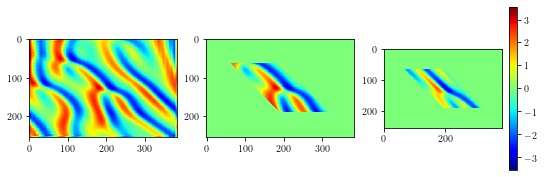

In [850]:
space_padded_state =np.pad(minimal_cover[0].resize(128,128).change_reference_frame(to='physical').state-0.38, 
                  ((64,64),(128,128)))

shp = space_padded_state.shape[0]//2
for i in range(0, shp):
    space_padded_state[i,:] = np.roll(space_padded_state[i,:].reshape(1,-1), -(shp-i), axis=1)
for i in range(-1, -shp, -1):
    space_padded_state[i,:] = np.roll(space_padded_state[i,:].reshape(1,-1), (shp+i), axis=1)
    
parallelogram = space_padded_state.copy()
blue_shifted = clip(large_patch.roll(-10, axis=1).roll(4, axis=0), ((60, 100), (22, 26)))
umin, umax = blue_shifted.state.min(), blue_shifted.state.max()
maxval = np.max(np.abs([umin, umax]))
blue_shifted_state = blue_shifted.resize(*parallelogram.shape).state
parallelogram_mask = parallelogram.astype(bool)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9,3))
ax0.imshow(blue_shifted_state, cmap='jet', vmin=-maxval, vmax=maxval)
ax1.imshow(parallelogram_mask*blue_shifted_state, cmap='jet', vmin=-maxval, vmax=maxval)
im = ax2.imshow(parallelogram, cmap='jet', vmin=-maxval, vmax=maxval)
plt.colorbar(im)

With this manipulation, the $L_2$ distance could be computed between the covering orbits and the patches of space-time, however, I suspect that this construction might be time consuming.

#### Missed patterns

Additionally, there *do* seem to be patterns which may not have been captured; it is precarious because these patterns look as though they may be combinations of the current cover's patterns; whatever the case it seems they do not occur with high frequency, unlike the regions previously described above. One example of a pattern that is hard to capture is this "tree-like" structure (as in the acyclic graph) which seemingly is repeated combinations of the defect tile; or perhaps higher order defects. The 3-to-1 defect exists but it wasn't clear to me whether it was important enough to warrant its inclusion; this requires more testing.

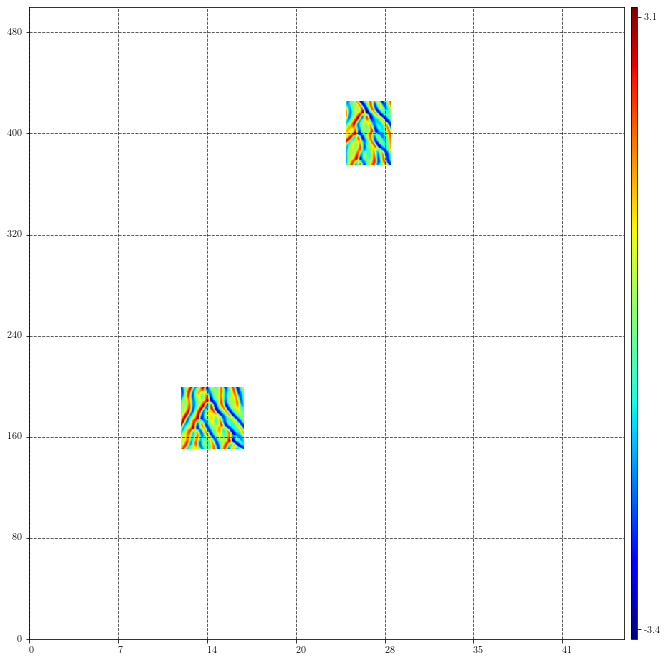

In [386]:
clipping_mask(large_patch, [((150, 200),(12,17)), ((375, 425),(25, 28.5))]).plot(padding=False)

The same search as above but with more lax thresholds.

In [861]:
minimal_cover = read_h5('minimal_cover.h5')

strictness = 1
critical_values_lax = []
with h5py.File('critical_values.h5', 'r') as file:
    critical_values_lax.append(file['defect/l2_difference'][...][strictness])
    critical_values_lax.append(file['drifter/l2_difference'][...][strictness])
    critical_values_lax.append(file['large_defect/l2_difference'][...][strictness])
    critical_values_lax.append(file['wiggle/l2_difference'][...][strictness])

with h5py.File('critical_values.h5', 'r') as file:
    critical_values_lax.append(file['defect/l2_difference_fundamental_domain'][...][strictness])
    critical_values_lax.append(file['drifter/l2_difference_fundamental_domain'][...][strictness])
    critical_values_lax.append(file['large_defect/l2_difference_fundamental_domain'][...][strictness])
    critical_values_lax.append(file['wiggle/l2_difference_fundamental_domain'][...][strictness])


In [874]:
lax_families = []
t0_full_cover = time.time_ns()/10**9
lax_critical_values = []
for root, l2_cval in zip(minimal_cover, critical_values_lax[:4]):
    tmp = tuple(root.group_orbit(rolls=(12, 12), fundamental_domain=False))
    lax_families.append(tmp)
    lax_critical_values.append([l2_cval]*len(tmp))
                                  
for root, l2_cval in zip(minimal_cover, critical_values_lax[4:]):
    tmp = tuple(root.group_orbit(rolls=(12, 12), fundamental_domain=True))
    lax_families.append(tmp)
    lax_critical_values.append([l2_cval]*len(tmp))


In [895]:
lax_covers = []
t0_full_cover = time.time_ns()/10**9
for family, family_critical_values in zip(lax_families, lax_critical_values):
    # actually single orbits, put into tuple to abide by requirements. 
    lax_family_covering = cover(large_patch, tuple(family_critical_values), tuple(family),
                                score_type='pointwise',
                                scoring_function=l2_difference,
                                replacement=False,
                                base_orbit_periodicity=(False, True),
                                strides=(1,1),
                                verbose=False)
    lax_covers.append(lax_family_covering)
t1_full_cover = time.time_ns()/10**9

KeyboardInterrupt: 

In [938]:
base_size = base.size

In [949]:
mask_window = base_orbit_mask[pivot_grid]
# This is the number of unfilled points divided by total number of points in base discretization
unfilled_spacetime_within_window = mask_window[mask_window == 0.].size / base_size

In [991]:
window = minimal_cover[0]

In [993]:
base_orbit_mask = np.zeros(base.shape, dtype=float)
weights = np.zeros(len(family), dtype=float)

In [994]:
base_orbit_mask = base_orbit_mask.astype(float)

In [1006]:
base_orbit_windowed = base_orbit_mask[pivot_grid]
# This is the number of unfilled points divided by total number of points in base discretization
unfilled_spacetime_within_window = base_orbit_windowed[base_orbit_windowed == 0.].size / base_size
# weights[detected_orbit_index] += unfilled_spacetime_within_window

In [1040]:
mask_pivot_tuples = ((1,1),)
grid = np.indices(minimal_cover[0].shape)
base_mask = np.zeros(base.shape, dtype=bool)

# For each window pivot (equivalently, "top left" corner) compute the indices within the span of the window.
# Once these indices have been determined, the corresponding values in the orbit mask can be set to True.
for pivot_tuple in mask_pivot_tuples:
    # pivot grid is a tuple of coordinates, the first dimension's indices are stored in the first element, etc.
    # Each pivot_grid element is the same dimension as the window. The indices are essentially the pivot + window
    # indices.
    pivot_grid = tuple(g + p*s for g, p, s in zip(grid, pivot_tuple, strides))
    # To account for wrapping, fold indices which extend beyond the base orbit's extent using periodicity.
    for coordinates, base_extent in zip(pivot_grid, base.shape):
        coordinates[coordinates >= base_extent] -= base_extent

# Full search with smaller patches

Before moving on with the full run, these results need to be discussed. 